<a href="https://colab.research.google.com/github/evalcas/climate-variables-senamhi-augusto-weberbauer-cajamarca-1994-2024/blob/main/Dataset_Imputation_Senamhi30Year.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis y Evaluación de Métodos de Imputación para Series Temporales de Variables Ambientales en Datos Climatológicos - Estación Augusto Weberbauer (Cajamarca, Perú)

* Objetivo del Notebook: Analizar, documentar y comparar un conjunto representativo de métodos de imputación, con énfasis en su aplicabilidad a series temporales de variables ambientales diarias de 30 años

* Fuente de Datos: Los datos fueron proporcionados por el SENAMHI para la ciudad de Cajamarca en Perú, el periodo abarca desde enero del 1994 a diciembre del 2024.

* Variables Climatológicas Procesadas y Evaluadas:
    - **DailyPrecipitation** (precipitación diaria)
    - **AverageTemperature** (temperatura media)
    - **RelativeHumidity** (humedad relativa)
    - **AtmosphericPressure** (presión atmosférica)
    - **WindSpeed** (velocidad del viento)
    - **SunshineHours** (horas de sol)

* Repositorio y Autoría:
Edwin Valencia-Castillo, & Sandra Rodriguez-Avila. (2025). Climate Variables from SENAMHI Augusto Weberbauer Station (Cajamarca, Peru), 1994–2024 (v1.1.0). Zenodo. https://doi.org/10.5281/zenodo.15803715

## Introducción

La calidad de los datos es fundamental en el análisis de series temporales ambientales. Sin embargo, en muchas ocasiones, los registros climáticos y meteorológicos presentan vacíos de información debidos a fallas en los sensores, problemas logísticos, errores humanos o eventos extraordinarios como desastres naturales o pandemias. En este contexto, la **imputación de datos faltantes** se vuelve una tarea crítica para garantizar la integridad de los análisis posteriores.

## Estructura del Análisis

Se ha identificado varios métodos de imputacion aplicables a variables ambientales, estos son:

| Método                                | Definición Básica                                                                                                                                                                                                                                 |
| ------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Media estacional**                  | Sustituye valores faltantes con la media calculada para cada categoría estacional (por ejemplo, mes o día del año), preservando la estacionalidad anual en la serie.                                                                              |
| **Interpolación estacional**          | Estima los valores faltantes mediante interpolación (lineal, cúbica, spline, etc.) dentro de cada categoría estacional, respetando la estructura temporal repetitiva.                                                                             |
| **STL con interpolación**             | Descompone la serie en componentes de tendencia, estacionalidad y residuo mediante el algoritmo STL (*Seasonal-Trend decomposition using Loess*) e interpola solo la parte residual para evitar distorsionar la estacionalidad.                   |
| **KNN con estacionalidad**            | Imputa cada valor faltante usando un promedio ponderado de los *k* vecinos más cercanos en el espacio multivariable, considerando únicamente aquellos que pertenecen a la misma categoría estacional.                                             |
| **MICE con estacionalidad**           | Método iterativo de imputación multivariable que modela cada variable con datos faltantes en función de las demás, incluyendo indicadores estacionales como variables predictoras en cada modelo.                                                 |
| **Análisis Espectral Singular (SSA)** | Descompone la serie temporal en componentes principales (tendencia, oscilaciones periódicas y ruido) mediante técnicas espectrales; reconstruye la señal eliminando el ruido y sustituyendo los valores faltantes con la reconstrucción estimada. |
| **Regresión temporal**                | Ajusta un modelo de regresión univariado o multivariado, en función del tiempo y/o de otras variables predictoras, para estimar los valores faltantes siguiendo la evolución de la serie.                                                         |

---

## Enfoque de Evaluación

Luego de la descripción de cada uno de los métodos y su fundamento teórico, se desarrollará una **evaluación comparativa integral**, sustentada en un enfoque estadístico y estructural. Para ello, se implementarán las siguientes métricas de evaluación:

- **Diferencias estadísticas**: Comparación de medidas de tendencia central (media), dispersión (desviación estándar), simetría y curtosis entre la serie original y la imputada.
- **Dinámica temporal**: Análisis de similitud en la evolución de la serie imputada respecto al comportamiento temporal original.
- **Estructura y complejidad temporal**: Medidas basadas en técnicas de análisis de recurrencia, entropía o autocorrelación para evaluar la preservación de la complejidad intrínseca de la serie.
- **Conservación de eventos extremos**: Evaluación de la capacidad del método para no distorsionar ni suavizar excesivamente eventos atípicos o extremos importantes desde el punto de vista ambiental.

---

## Resultado Esperado

Como resultado del análisis, se identificará el o los **métodos de imputación más apropiados para cada variable ambiental**, considerando su comportamiento estadístico y estructura temporal característica. Esta selección se basará en evidencia empírica y respaldo bibliográfico, garantizando un enfoque riguroso y reproducible para futuras aplicaciones en el contexto de climatología, hidrología y otras ciencias ambientales.


In [156]:
# ================================
# Manejo de advertencias
# ================================
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ================================
# Manipulación y procesamiento de datos
# ================================
import pandas as pd
import numpy as np
import time

# ================================
# Visualización de datos
# ================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
# Solo en Jupyter o Colab

# ================================
# Imputación y preprocesamiento
# ================================
from sklearn.experimental import enable_iterative_imputer  # Habilita IterativeImputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder

# ================================
# Modelado estadístico y regresión
# ================================
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor

# ================================
# Series temporales y descomposición
# ================================
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

# ================================
# Métodos espectrales y SSA
# ================================
from scipy.linalg import svd
from pyts.decomposition import SingularSpectrumAnalysis

# ================================
# Estadísticas avanzadas y entropía
# ================================
from scipy.stats import kurtosis, skew, entropy
from antropy import sample_entropy, app_entropy
from pyunicorn.timeseries import RecurrencePlot

# ================================
# Evaluación de modelos
# ================================
from sklearn.metrics import mean_absolute_error

# Ignora específicamente las advertencias de tipo FutureWarning que podrían aparecer al utilizar funciones
# que cambiarán en versiones futuras de bibliotecas como pandas o numpy.
warnings.filterwarnings("ignore", category=FutureWarning)

In [157]:
# URL del archivo Excel en GitHub

url = 'https://github.com/evalcas/climate-variables-senamhi-augusto-weberbauer-cajamarca-1994-2024/blob/main/dataset_preprocessed_senamhi30Year.xlsx?raw=true'
excel_file = url

df_procesado = pd.read_excel(excel_file)

In [158]:
print(df_procesado.head())

  ProcessDate  Year  Month  Day  DailyPrecipitation  AverageTemperature  \
0  1994-01-01  1994      1    1                 0.2                14.9   
1  1994-01-02  1994      1    2                 7.7                15.1   
2  1994-01-03  1994      1    3                 0.0                14.0   
3  1994-01-04  1994      1    4                 0.0                15.3   
4  1994-01-05  1994      1    5                 5.1                15.1   

   RelativeHumidity  AtmosphericPressure  WindSpeed  SunshineHours  
0              76.2                740.1        1.3            6.8  
1              77.8                739.9        1.3            1.6  
2              73.1                739.5        1.7            6.8  
3              66.9                740.2        NaN            3.5  
4              72.0                740.1        2.0            6.2  


In [159]:
# usando df_procesado creamos un indice fecha utilizando la columna ProcessDate
# se verifica que no haya fechas faltantes, si los hay se visualizan
# luego se muestra los datos faltantes del df_procesado

# Establecer 'ProcessDate' como índice
df_procesado = df_procesado.set_index('ProcessDate')

# Verificar fechas faltantes
fechas_minima = df_procesado.index.min()
fechas_maxima = df_procesado.index.max()

rango_fechas = pd.date_range(start=fechas_minima, end=fechas_maxima)
fechas_faltantes = rango_fechas.difference(df_procesado.index)

if not fechas_faltantes.empty:
  print("Fechas faltantes:")
  print(fechas_faltantes)
else:
  print("No hay fechas faltantes en el DataFrame.")

# Mostrar datos faltantes en el DataFrame
print("\nDatos faltantes en df_procesado:")
print(df_procesado.isna().sum())

No hay fechas faltantes en el DataFrame.

Datos faltantes en df_procesado:
Year                      0
Month                     0
Day                       0
DailyPrecipitation      137
AverageTemperature      396
RelativeHumidity        508
AtmosphericPressure     327
WindSpeed              1288
SunshineHours           163
dtype: int64


In [160]:
# muestra informacion de los valores faltantes relacionados a su proporcion y distribucion expresado en porcentaje de la variables del dataset df_procesado

# Calcular el porcentaje de valores faltantes por columna
missing_percentage = df_procesado.isnull().sum() * 100 / len(df_procesado)

# Crear un DataFrame para mostrar la información
missing_info = pd.DataFrame({
    'Variable': missing_percentage.index,
    'Missing count': df_procesado.isnull().sum().values,
    'Missing percentage': missing_percentage.values
})

# Ordenar por porcentaje de valores faltantes (de mayor a menor)
missing_info = missing_info.sort_values(by='Missing percentage', ascending=False)

# Mostrar la información
missing_info


,Variable,Missing count,Missing percentage
7,WindSpeed,1288,11.375077
5,RelativeHumidity,508,4.486444
4,AverageTemperature,396,3.497306
6,AtmosphericPressure,327,2.887927
8,SunshineHours,163,1.439548
3,DailyPrecipitation,137,1.209927
0,Year,0,0.000000
1,Month,0,0.000000
2,Day,0,0.000000


In [161]:
df_procesado.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1994-01-01 to 2024-12-31
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 11323 non-null  int64  
 1   Month                11323 non-null  int64  
 2   Day                  11323 non-null  int64  
 3   DailyPrecipitation   11186 non-null  float64
 4   AverageTemperature   10927 non-null  float64
 5   RelativeHumidity     10815 non-null  float64
 6   AtmosphericPressure  10996 non-null  float64
 7   WindSpeed            10035 non-null  float64
 8   SunshineHours        11160 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 884.6 KB


In [27]:
# pip install pyts instalarlo en el terminal desde el venv

In [164]:


# ===============================
# METODOS DEIMPUTACIÓN DE DATOS AMBIENTALES IMPLEMENTADOS
# ===============================

# ===============================
# PAQUETES
# ===============================

# ============================================
# Núcleo científico y manipulación de datos
# ============================================
import numpy as np
import pandas as pd
import time

# ===============================
# Visualización de datos
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Manejo de advertencias
# ================================
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# =============================================
# Imputación de datos y preprocesamiento
# =============================================
from sklearn.experimental import enable_iterative_imputer  # Habilita IterativeImputer
from sklearn.impute import (
    KNNImputer,
    IterativeImputer,
    SimpleImputer
)

from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder
)

# ============================================
# Modelado estadístico y regresión
# ============================================
from sklearn.linear_model import (
    LinearRegression,
    BayesianRidge,
    Ridge
)

from sklearn.neighbors import KNeighborsRegressor

# ================================================
# Series temporales y descomposición estacional
# ================================================
from statsmodels.tsa.seasonal import STL, seasonal_decompose

# ============================================
# Álgebra lineal y métodos espectrales
# ============================================
from scipy.linalg import svd
from pyts.decomposition import SingularSpectrumAnalysis

# Instala la librería de SSA si no la tienes
# !pip install pyts

# ===============================
# MÉTODOS DE IMPUTACIÓN
# ===============================

def media_estacional(df, columnas):
    """
    Imputa valores faltantes usando la media estacional (promedio por mes y día).
    
    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame original con columnas 'Year', 'Month', 'Day' y un índice de fecha llamado 'ProcessDate'.
    columnas : list of str
        Lista de nombres de columnas a imputar.
    
    Retorna:
    --------
    df_imputado : pd.DataFrame
        Copia del DataFrame con los valores imputados.
    
    """
    df_imputado = df.copy()
    
    for col in columnas:
        # Agrupar por estacionalidad: mes y día
        for (m, d), grupo in df.groupby(['Month', 'Day']):
            # Calcular la media estacional ignorando los NaN
            media = grupo[col].mean(skipna=True)
            
            # Crear máscara para ubicar valores faltantes en esa categoría estacional
            mask = (df['Month'] == m) & (df['Day'] == d) & (df[col].isna())
            
            # Asignar la media estacional a los valores faltantes
            df_imputado.loc[mask, col] = media
            
    return df_imputado


def interpolacion_estacional(df, columnas, metodo='linear'):
    """
    Imputa valores faltantes usando interpolación estacional (por mes y día).
    
    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame original con columnas 'Year', 'Month', 'Day' y un índice datetime llamado 'ProcessDate'.
    columnas : list of str
        Lista de nombres de columnas a imputar.
    metodo : str
        Método de interpolación a aplicar ('linear', 'spline', 'polynomial', etc.).
        
    Retorna:
    --------
    df_imputado : pd.DataFrame
        Copia del DataFrame con los valores imputados.
    """
    df_imputado = df.copy()
    
    for col in columnas:
        # Agrupación por estacionalidad (mes y día)
        for (m, d), grupo in df.groupby(['Month', 'Day']):
            # Extraer el subconjunto estacional
            subgrupo = grupo[[col]].copy()
            
            # Solo si hay al menos 2 datos no nulos se puede interpolar
            if subgrupo[col].notna().sum() >= 2:
                # Interpolar valores dentro del subconjunto usando el índice de fechas
                interpolado = subgrupo[col].interpolate(method=metodo, limit_direction='both')
                
                # Actualizar solo los valores faltantes en el DataFrame original
                mask = (df['Month'] == m) & (df['Day'] == d) & (df[col].isna())
                df_imputado.loc[mask, col] = interpolado.loc[mask]
    
    return df_imputado


def stl_interpolacion(df, columnas, periodo=365, metodo='linear'):
    """
    Imputa valores faltantes utilizando la descomposición STL seguida de interpolación de la componente residual.
    
    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame original con un índice datetime llamado 'ProcessDate'.
    columnas : list of str
        Lista de nombres de columnas a imputar.
    periodo : int
        Periodo estacional de la serie (e.g., 365 para series diarias con estacionalidad anual).
    metodo : str
        Método de interpolación a aplicar sobre los residuos ('linear', 'spline', 'polynomial', etc.).
    
    Retorna:
    --------
    df_imputado : pd.DataFrame
        Copia del DataFrame con las variables imputadas mediante STL + interpolación.
    
    """
    df_imputado = df.copy()
    
    for col in columnas:
        serie = df[col]
        
        # Asegurarse de que la serie tenga índice datetime
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("El DataFrame debe estar indexado por fechas (DatetimeIndex).")
        
        # STL requiere series completas sin huecos, se rellena temporalmente para descomponer
        serie_temp = serie.copy()
        serie_temp = serie_temp.interpolate(method='linear', limit_direction='both')

        # Aplicar STL
        stl = STL(serie_temp, period=periodo, robust=True)
        result = stl.fit()
        
        tendencia = result.trend
        estacional = result.seasonal
        residuo = serie - tendencia - estacional  # Residuo real (puede contener NaNs)
        
        # Interpolación del residuo
        residuo_interp = residuo.interpolate(method=metodo, limit_direction='both')
        
        # Reconstruir la serie imputada
        serie_imputada = tendencia + estacional + residuo_interp
        
        # Reemplazar solo los valores faltantes en la serie original
        df_imputado[col] = serie.where(serie.notna(), serie_imputada)
        
    return df_imputado

def knn_estacional(df, columnas, k=5, estacionalidad='DayOfYear', variables_auxiliares=None):
    """
    Imputación basada en KNN considerando estacionalidad (e.g., por día del año).

    Parámetros:
    ----------
    df : pd.DataFrame
        DataFrame con las columnas 'Year', 'Month', 'Day' y variables a imputar.
    columnas : list of str
        Nombres de las columnas con valores faltantes que se desean imputar.
    k : int
        Número de vecinos a considerar para KNN.
    estacionalidad : str
        Nombre de la columna que define la estacionalidad (por defecto: 'DayOfYear').
    variables_auxiliares : list of str or None
        Variables auxiliares para usar como predictores junto a cada variable objetivo. Si es None, usa todas las columnas.

    Retorna:
    -------
    df_imputado : pd.DataFrame
        DataFrame con los valores imputados usando KNN por grupo estacional.
    """

    df_imputado = df.copy()

    # Verifica y crea la columna estacional si no existe
    if estacionalidad == 'DayOfYear' and 'DayOfYear' not in df_imputado.columns:
        df_imputado['DayOfYear'] = pd.to_datetime(
            df_imputado[['Year', 'Month', 'Day']]
        ).dt.dayofyear

    for col in columnas:
        # Selecciona las variables auxiliares, excluyendo la variable actual
        predictores = [col]
        if variables_auxiliares:
            predictores += [v for v in variables_auxiliares if v != col]
        predictores = list(dict.fromkeys(predictores))  # Elimina duplicados conservando orden

        df_temp = df_imputado[predictores + [estacionalidad]].copy()

        # Imputación por grupo estacional
        for d, grupo in df_temp.groupby(estacionalidad):
            subgrupo = grupo[predictores]

            # Omitir si todos los valores están vacíos en la variable objetivo
            if subgrupo[col].isna().all():
                continue

            # Aplica KNN solo si hay valores observados
            try:
                imputer = KNNImputer(n_neighbors=k)
                imputado = imputer.fit_transform(subgrupo)

                # Actualiza los valores imputados
                df_imputado.loc[grupo.index, col] = imputado[:, 0]
            except Exception as e:
                print(f"[Aviso] No se pudo imputar para {col} en {estacionalidad}={d}: {e}")

    return df_imputado


def mice_con_estacionalidad(df, columnas, estacionalidad='DayOfYear', n_iter=10, correl_threshold=0.3, min_aux=1):
    """
    Imputación robusta con MICE considerando estacionalidad, con imputación global de respaldo.
    
    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame original con variables ambientales y columnas 'Year', 'Month', 'Day'.
    columnas : list of str
        Nombres de columnas objetivo para imputar.
    estacionalidad : str
        Estacionalidad a considerar: 'DayOfYear' o 'Month'.
    n_iter : int
        Número de iteraciones para el imputador MICE.
    correl_threshold : float
        Umbral de correlación mínima para seleccionar variables auxiliares.
    min_aux : int
        Número mínimo de variables auxiliares requeridas por estación.

    Retorna:
    --------
    df_resultado : pd.DataFrame
        Copia del DataFrame original con las imputaciones aplicadas.
    """
    from sklearn.linear_model import BayesianRidge
    from sklearn.impute import IterativeImputer
    from sklearn.preprocessing import RobustScaler

    df_resultado = df.copy()

    # Crear columna de estacionalidad si no existe
    if estacionalidad == 'DayOfYear':
        if 'DayOfYear' not in df_resultado.columns:
            df_resultado['DayOfYear'] = pd.to_datetime(df_resultado[['Year', 'Month', 'Day']]).dt.dayofyear
        grupo_estacional = 'DayOfYear'
    elif estacionalidad == 'Month':
        grupo_estacional = 'Month'
    else:
        raise ValueError("Estacionalidad no válida. Use 'DayOfYear' o 'Month'.")

    for var in columnas:
        if df_resultado[var].isna().sum() == 0:
            print(f"'{var}' no tiene valores faltantes. Se omite imputación.")
            continue

        sub_df = df_resultado[columnas + [grupo_estacional]].copy()
        aux_por_estacion = {}

        for estacion in sub_df[grupo_estacional].dropna().unique():
            sub_e = sub_df[sub_df[grupo_estacional] == estacion].dropna()
            if len(sub_e) < 10:
                continue

            corr = sub_e.corr(numeric_only=True)
            if var in corr.columns:
                correladas = corr[var].drop(var).abs()
                aux_vars = correladas[correladas >= correl_threshold].index.tolist()
                if len(aux_vars) >= min_aux:
                    aux_por_estacion[estacion] = aux_vars

        imputados_idx = []

        # Imputación por estación
        for estacion, aux_vars in aux_por_estacion.items():
            df_estacion = df_resultado[df_resultado[grupo_estacional] == estacion]
            if len(aux_vars) == 0 or df_estacion[var].isna().sum() == 0:
                continue

            columnas_modelo = [var] + aux_vars
            df_temp = df_estacion[columnas_modelo].copy()

            # Evitar columnas totalmente faltantes
            if df_temp.dropna().shape[0] < 10:
                continue

            scaler = RobustScaler()
            df_scaled = pd.DataFrame(scaler.fit_transform(df_temp), columns=columnas_modelo, index=df_temp.index)

            imputador = IterativeImputer(estimator=BayesianRidge(), max_iter=n_iter, random_state=42)
            df_imputado = imputador.fit_transform(df_scaled)

            df_imputado = pd.DataFrame(df_imputado, columns=columnas_modelo, index=df_temp.index)
            imputacion_final = scaler.inverse_transform(df_imputado)

            df_resultado.loc[df_temp.index, var] = imputacion_final[:, 0]
            imputados_idx.extend(df_temp.index.tolist())

        # Imputación global complementaria (solo sobre faltantes)
        faltantes_post_estacional = df_resultado[var].isna()
        if faltantes_post_estacional.sum() > 0:
            aux_global = []
            sub_corr = df_resultado[columnas].dropna().corr()
            if var in sub_corr.columns:
                correladas = sub_corr[var].drop(var).abs()
                aux_global = correladas[correladas >= correl_threshold].index.tolist()

            if len(aux_global) >= min_aux:
                columnas_modelo = [var] + aux_global
                df_temp = df_resultado.loc[faltantes_post_estacional, columnas_modelo].copy()
                df_total = df_resultado[columnas_modelo].copy()

                # Reentrenar sobre todo el conjunto
                scaler = RobustScaler()
                df_scaled = pd.DataFrame(scaler.fit_transform(df_total), columns=columnas_modelo, index=df_total.index)

                imputador = IterativeImputer(estimator=BayesianRidge(), max_iter=n_iter, random_state=42)
                imputador.fit(df_scaled)

                # Solo aplicar a faltantes
                df_pred = df_resultado.loc[faltantes_post_estacional, columnas_modelo]
                df_pred_scaled = pd.DataFrame(scaler.transform(df_pred), columns=columnas_modelo, index=df_pred.index)
                imputado = imputador.transform(df_pred_scaled)

                imputacion_final = scaler.inverse_transform(imputado)
                df_resultado.loc[df_pred.index, var] = imputacion_final[:, 0]

        # Reporte
        #faltantes_final = df_resultado[var].isna().sum()
        #imputados = df[var].isna().sum() - faltantes_final
        #print(f"  {var}: {imputados} imputados, {faltantes_final} aún faltantes")

    return df_resultado

def imputacion_ssa(df, columnas, L=365, k_max=10):
    """
    Imputación de datos faltantes mediante Análisis Espectral Singular (SSA).

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con series temporales indexadas por fecha y columnas 'Year', 'Month', 'Day'.
    columnas : list of str
        Columnas a imputar mediante SSA.
    L : int
        Longitud de la ventana de descomposición (debe cumplir 2 ≤ L ≤ N/2). Idealmente ≈ estacionalidad (e.g., 365).
    k_max : int
        Número máximo de componentes singulares a retener para reconstrucción (SSA truncado).

    Retorna:
    --------
    df_resultado : pd.DataFrame
        DataFrame con imputaciones aplicadas por SSA a cada variable.
    """
    df_resultado = df.copy()

    for var in columnas:
        #print(f"\n Imputando '{var}' mediante SSA...")

        serie_original = df_resultado[var].values.astype(float)
        nan_mask = np.isnan(serie_original)

        if not nan_mask.any():
            print(f"'{var}' no contiene valores faltantes.")
            continue

        N = len(serie_original)
        if L >= N // 2:
            L = N // 3  # Ajustar L si es muy grande

        K = N - L + 1

        # Paso 1: completar con media estacional previa (inicialización)
        serie_aux = serie_original.copy()
        mean_value = np.nanmean(serie_aux)
        serie_aux[nan_mask] = mean_value

        # Paso 2: Construcción de matriz de trayectoria
        X = np.column_stack([serie_aux[i:L+i] for i in range(K)])

        # Paso 3: SVD
        U, s, VT = svd(X, full_matrices=False)
        d = min(k_max, len(s))  # truncar si necesario
        X_recon = np.zeros((L, K))

        for i in range(d):
            X_recon += s[i] * np.outer(U[:, i], VT[i, :])

        # Paso 4: Reconstrucción de la serie (diagonal averaging)
        x_recon = np.zeros(N)
        counts = np.zeros(N)

        for i in range(L):
            for j in range(K):
                x_recon[i + j] += X_recon[i, j]
                counts[i + j] += 1

        x_recon = x_recon / counts

        # Paso 5: Reemplazar solo donde hay NA
        serie_final = serie_original.copy()
        serie_final[nan_mask] = x_recon[nan_mask]

        df_resultado[var] = serie_final
        #print(f" Imputación completada para '{var}'.")

    return df_resultado

def temporal_estacional(df, columnas, estacionalidad='DayOfYear', alpha=1.0, correl_threshold=0.3):
    """
    Imputación robusta basada en regresión temporal con estacionalidad, tendencia temporal y variables auxiliares.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original con columnas 'Year', 'Month', 'Day' y las variables a imputar.
    columnas : list
        Lista de nombres de columnas a imputar.
    estacionalidad : str
        Variable estacional ('DayOfYear' o 'Month').
    alpha : float
        Parámetro de regularización para Ridge.
    correl_threshold : float
        Umbral mínimo de correlación para incluir variables auxiliares.

    Retorna
    -------
    df_imputado : pd.DataFrame
        DataFrame con los valores imputados.
    """

    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    df_imputado = df.copy()

    # Verificación y cálculo de 'DayOfYear' y 'TiempoDecimal'
    if 'DayOfYear' not in df_imputado.columns or 'TiempoDecimal' not in df_imputado.columns:
        df_imputado['Date'] = pd.to_datetime(df_imputado[['Year', 'Month', 'Day']])
        df_imputado['DayOfYear'] = df_imputado['Date'].dt.dayofyear
        df_imputado['TiempoDecimal'] = df_imputado['Year'] + (df_imputado['DayOfYear'] - 1) / 365.25

    for var in columnas:
        idx_missing = df_imputado[var].isna()
        idx_notna = ~idx_missing

        if idx_notna.sum() < 10:
            continue  # Insuficientes datos para entrenamiento

        # Selección de variables auxiliares por correlación
        otras_vars = [v for v in columnas if v != var]
        correlaciones = df_imputado[otras_vars].corrwith(df_imputado[var])
        pred_vars = correlaciones[correlaciones.abs() > correl_threshold].index.tolist()

        if not pred_vars:
            continue  # No hay predictores adecuados

        # Codificación estacional
        if estacionalidad == 'DayOfYear':
            est_values = 2 * np.pi * df_imputado['DayOfYear'] / 365.25
        elif estacionalidad == 'Month':
            est_values = 2 * np.pi * df_imputado['Month'] / 12
        else:
            raise ValueError("Estacionalidad debe ser 'DayOfYear' o 'Month'")

        df_imputado['sin_est'] = np.sin(est_values)
        df_imputado['cos_est'] = np.cos(est_values)

        # Construcción de la matriz de predictores
        X_full = df_imputado[pred_vars + ['sin_est', 'cos_est', 'TiempoDecimal']].copy()

        # Reemplazo de infinitos o valores extremos
        X_full = X_full.replace([np.inf, -np.inf], np.nan)
        X_full = X_full.clip(lower=X_full.quantile(0.01), upper=X_full.quantile(0.99), axis=1)

        # Imputación de valores faltantes en predictores
        imputer = SimpleImputer(strategy='mean')
        X_full = pd.DataFrame(imputer.fit_transform(X_full), columns=X_full.columns, index=X_full.index)

        # Escalado robusto
        scaler = RobustScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_full), columns=X_full.columns, index=X_full.index)

        # Validación final de los predictores
        if X_scaled.loc[idx_notna].isnull().any().any() or X_scaled.loc[idx_missing].isnull().any().any():
            continue

        X_train = X_scaled.loc[idx_notna]
        y_train = df_imputado.loc[idx_notna, var]
        X_pred = X_scaled.loc[idx_missing]

        if X_train.shape[0] < 10 or X_pred.empty:
            continue

        try:
            modelo = Ridge(alpha=alpha)
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_pred)

            if np.isfinite(y_pred).all():
                df_imputado.loc[idx_missing, var] = y_pred
        except Exception as e:
            print(f"[Error] Fallo en imputar '{var}': {e}")
            continue

    return df_imputado

# ===============================
# APLICACIÓN DE LOS MÉTODOS
# ===============================
# Diccionarios para almacenar resultados de ejecución de funciones de imputación
tiempos_ejecucion = {}
datos_imputados_por_metodo = {}

# Función para contar imputados por variable
def contar_imputados(df_original, df_imputado, columnas):
    return {
        col: df_original[col].isnull().sum() - df_imputado[col].isnull().sum()
        for col in columnas
    }

# Función general para medir tiempo y registrar imputación
def medir_imputacion(nombre_metodo, funcion, df_original, columnas, *args, **kwargs):
    print(f"Ejecutando {nombre_metodo}...")
    df_input = df_original.copy()
    inicio = time.time()
    df_resultado = funcion(df_input, columnas, *args, **kwargs)
    duracion = time.time() - inicio

    # Guardar tiempo y datos imputados
    tiempos_ejecucion[nombre_metodo] = round(duracion, 2)
    datos_imputados_por_metodo[nombre_metodo] = contar_imputados(df_original, df_resultado, columnas)

    print(f"{nombre_metodo} completado en {duracion:.2f} segundos.\n")
    return df_resultado

columnas = [
    'DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity',
    'AtmosphericPressure', 'WindSpeed', 'SunshineHours'
]

# Asegurar que los datos están ordenados
df_procesado = df_procesado.sort_values(by=['Year', 'Month', 'Day'])

#MEDIA ESTACIONAL → Seasonal Mean Imputation
#INTERPOLACIÓN ESTACIONAL → Seasonal Interpolation
#INTERPOLACIÓN STL → STL-Based Interpolation
#KNN ESTACIONAL → Seasonal KNN Imputation
#MICE ESTACIONAL → Seasonal MICE Imputation 
#SSA → Singular Spectrum Analysis SSA-based Imputation
#TEMPORAL ESTACIONAL → Seasonal Temporal Regression Imputation

# Ejecutar funciones de imputcion con medición
df_med_estacional = medir_imputacion("Seasonal Mean Imputation", media_estacional, df_procesado, columnas)
df_interp_estacional = medir_imputacion("Seasonal Interpolation", interpolacion_estacional, df_procesado, columnas)
df_stl_interp = medir_imputacion("STL-Based Interpolation", stl_interpolacion, df_procesado, columnas, periodo=365, metodo='linear')
df_knn_estacional = medir_imputacion("Seasonal KNN Imputation", knn_estacional, df_procesado, columnas, k=5, estacionalidad='DayOfYear', variables_auxiliares=columnas)
df_mice = medir_imputacion("Seasonal MICE Imputation", mice_con_estacionalidad, df_procesado, columnas, estacionalidad='DayOfYear', n_iter=15, correl_threshold=0.1)
df_ssa = medir_imputacion("SSA-based Imputation", imputacion_ssa, df_procesado, columnas, L=365, k_max=10)
df_temporal_estacional = medir_imputacion("Seasonal Temporal Regression Imputation", temporal_estacional, df_procesado, columnas, estacionalidad='DayOfYear', alpha=1.0, correl_threshold=0.1)

# Reportes (opcional)
print("\n--- Imputaciones terminada con exito ---")

Ejecutando Seasonal Mean Imputation...
Seasonal Mean Imputation completado en 0.35 segundos.

Ejecutando Seasonal Interpolation...
Seasonal Interpolation completado en 0.90 segundos.

Ejecutando STL-Based Interpolation...
STL-Based Interpolation completado en 35.35 segundos.

Ejecutando Seasonal KNN Imputation...
Seasonal KNN Imputation completado en 1.93 segundos.

Ejecutando Seasonal MICE Imputation...
Seasonal MICE Imputation completado en 7.94 segundos.

Ejecutando SSA-based Imputation...
SSA-based Imputation completado en 6.27 segundos.

Ejecutando Seasonal Temporal Regression Imputation...
Seasonal Temporal Regression Imputation completado en 0.04 segundos.


--- Imputaciones terminada con exito ---


In [165]:
# Consolidar en DataFrame
def reporte_consolidado(datos_imputados, tiempos):
    filas = []
    for metodo, imputaciones in datos_imputados.items():
        fila = {"Método": metodo, "Tiempo (segundos)": tiempos[metodo]}
        fila.update(imputaciones)
        filas.append(fila)
    df_resumen = pd.DataFrame(filas)
    columnas_ordenadas = ["Método", "Tiempo (segundos)"] + columnas
    df_resumen = df_resumen[columnas_ordenadas]
    df_resumen = df_resumen.sort_values(by="Tiempo (segundos)", ascending=False)
    return df_resumen

# Mostrar el resumen
df_reporte_final = reporte_consolidado(datos_imputados_por_metodo, tiempos_ejecucion)
print("\n--- Reporte Consolidado de Imputación ---")
df_reporte_final.sort_index()



--- Reporte Consolidado de Imputación ---


,Método,Tiempo (segundos),DailyPrecipitation,AverageTemperature,RelativeHumidity,AtmosphericPressure,WindSpeed,SunshineHours
0,Seasonal Mean Imputation,0.35,137,396,508,327,1288,163
1,Seasonal Interpolation,0.90,137,396,508,327,1288,163
2,STL-Based Interpolation,35.35,137,396,508,327,1288,163
3,Seasonal KNN Imputation,1.93,137,396,508,327,1288,163
4,Seasonal MICE Imputation,7.94,137,396,508,327,1288,163
5,SSA-based Imputation,6.27,137,396,508,327,1288,163
6,Seasonal Temporal Regression Imputation,0.04,137,396,508,327,1288,163


# EVALUACION DE LA IMPUTACION

## 1. EVALUACION ESTADISTICA

Comparacion de Rangos y distribucion

* Rangos Históricos: Comprueba que los valores imputados se encuentren dentro de rangos razonables comparados con datos históricos.
* Estadísticas Descriptivas: Revisa la media, mediana, varianza, etc., antes y después de la imputación para detectar posibles sesgos.
* Histogramas: Grafica histogramas de la serie original e imputada para verificar que la forma de la distribución se mantenga.


## Rangos Historicos

Se calcula los valores mínimos y máximos históricos de cada variable y verificar que los valores imputados se mantengan dentro de ese rango.

Si hay valores fuera del rango histórico, podrías revisar si la imputación es adecuada.

In [167]:
# Rangos historicos con porcentajes de valores fueran de rango

def generar_tabla_rangos(df_original, df_imputados, columnas):
    """
    Genera una tabla de rangos históricos con porcentajes de valores fuera de rango para cada método de imputación.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        for columna in columnas:
            min_historico = df_original[columna].min()
            max_historico = df_original[columna].max()

            fuera_rango = df_imputado[
                (df_imputado[columna] < min_historico) |
                (df_imputado[columna] > max_historico)
            ]
            porcentaje_fuera_rango = (len(fuera_rango) / len(df_imputado)) * 100 if len(df_imputado) > 0 else 0

            resultados.append({
                'Imputation Method': nombre_metodo,
                'Variable': columna,
                'Historical Minimum': min_historico,
                'Historical Maximum': max_historico,
                'Out-of-Range Values': len(fuera_rango),
                'Percentage Out-of-Range': porcentaje_fuera_rango
            })
    return pd.DataFrame(resultados)

# Crear un diccionario con los DataFrames imputados
dataframes_imputados = {
    'Seasonal Mean Imputation':df_med_estacional, 
    'Seasonal Interpolation':df_interp_estacional,
    'STL-Based Interpolation':df_stl_interp, 
    'Seasonal KNN Imputation':df_knn_estacional,
    'Seasonal MICE Imputation':df_mice, 
    'SSA-based Imputation':df_ssa, 
    'Seasonal Temporal Regression Imputation':df_temporal_estacional 
}

# Generar y mostrar la tabla de rangos
tabla_rangos = generar_tabla_rangos(df_procesado, dataframes_imputados, columnas)
tabla_rangos


,Imputation Method,Variable,Historical Minimum,Historical Maximum,Out-of-Range Values,Percentage Out-of-Range
0,Seasonal Mean Imputation,DailyPrecipitation,0.0,51.8,0,0.000000
1,Seasonal Mean Imputation,AverageTemperature,10.6,18.5,0,0.000000
2,Seasonal Mean Imputation,RelativeHumidity,29.9,93.9,0,0.000000
3,Seasonal Mean Imputation,AtmosphericPressure,736.6,749.7,0,0.000000
4,Seasonal Mean Imputation,WindSpeed,0.0,8.3,0,0.000000
5,Seasonal Mean Imputation,SunshineHours,0.0,12.3,0,0.000000
6,Seasonal Interpolation,DailyPrecipitation,0.0,51.8,0,0.000000
7,Seasonal Interpolation,AverageTemperature,10.6,18.5,0,0.000000
8,Seasonal Interpolation,RelativeHumidity,29.9,93.9,0,0.000000
9,Seasonal Interpolation,AtmosphericPressure,736.6,749.7,0,0.000000


In [186]:
# Diferencias relativas en la media por cada metodo y variable entre series originales e imputadas

def generar_tabla_diferencias_relativas_media(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la media para cada método de imputación,
    formateada a cuatro decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Imputation Method': nombre_metodo}
        for columna in columnas:
            media_original = df_original[columna].mean()
            media_imputada = df_imputado[columna].mean()

            if media_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((media_imputada - media_original) / media_original) * 100

            fila[columna] = round(diferencia_relativa, 4) # Formato a 4 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_media = generar_tabla_diferencias_relativas_media(df_procesado, dataframes_imputados, columnas)
display(tabla_diferencias_media.style.hide(axis="index"))

Imputation Method,DailyPrecipitation,AverageTemperature,RelativeHumidity,AtmosphericPressure,WindSpeed,SunshineHours
Seasonal Mean Imputation,0.065600,0.043000,0.081200,-0.000400,-0.030200,-0.033400
Seasonal Interpolation,0.080000,0.070900,0.065700,-0.002000,1.042100,0.011200
STL-Based Interpolation,-0.338800,0.073000,0.164500,-0.001600,-3.502900,-0.502800
Seasonal KNN Imputation,-0.018500,0.025100,0.212700,-0.000400,-0.318000,-0.113300
Seasonal MICE Imputation,-0.025100,0.027200,0.191700,-0.000400,-0.369600,-0.011900
SSA-based Imputation,0.077800,0.049400,0.019600,-0.000100,0.025200,-0.005100
Seasonal Temporal Regression Imputation,-0.034600,0.071500,0.150600,-0.001200,0.152500,0.000200


In [187]:
# Diferencias relativas en la desviacion estandar por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cinco digitos

def generar_tabla_diferencias_relativas_std(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la desviación estándar para cada método de imputación,
    formateada a cuatro decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Imputation Method': nombre_metodo}
        for columna in columnas:
            std_original = df_original[columna].std()
            std_imputada = df_imputado[columna].std()

            if std_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((std_imputada - std_original) / std_original) * 100

            fila[columna] = round(diferencia_relativa, 4)  # Formato a 5 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_std = generar_tabla_diferencias_relativas_std(df_procesado, dataframes_imputados, columnas)
display(tabla_diferencias_std.style.hide(axis="index"))

Imputation Method,DailyPrecipitation,AverageTemperature,RelativeHumidity,AtmosphericPressure,WindSpeed,SunshineHours
Seasonal Mean Imputation,-0.519400,-1.467000,-1.782300,-1.295000,-5.115500,-0.629800
Seasonal Interpolation,-0.298300,-0.823900,-0.911000,-0.220800,-2.945300,-0.415500
STL-Based Interpolation,-0.476500,-0.570100,-0.258700,0.640800,-1.744700,0.042900
Seasonal KNN Imputation,-0.517100,-1.306900,-1.045400,-1.057200,-4.273100,-0.466800
Seasonal MICE Imputation,-0.531900,-1.393300,-0.912000,-1.257800,-4.570700,-0.588200
SSA-based Imputation,-0.596300,-1.461500,-1.712100,-1.324800,-5.715400,-0.684500
Seasonal Temporal Regression Imputation,-0.594900,-1.390400,-1.084900,-1.284100,-4.844900,-0.635900


In [188]:
# Diferencias relativas en la asimetria por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cinco digitos
from scipy.stats import kurtosis, skew

def generar_tabla_diferencias_relativas_asimetria(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la asimetría para cada método de imputación,
    formateada a cinco decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Imputation Method': nombre_metodo}
        for columna in columnas:
            asimetria_original = skew(df_original[columna].dropna()) #Usar dropna para evitar errores con datos faltantes
            asimetria_imputada = skew(df_imputado[columna].dropna())

            if asimetria_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((asimetria_imputada - asimetria_original) / asimetria_original) * 100

            fila[columna] = round(diferencia_relativa, 4)  # Formato a 5 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_asimetria = generar_tabla_diferencias_relativas_asimetria(df_procesado, dataframes_imputados, columnas)
display(tabla_diferencias_asimetria.style.hide(axis="index"))

Imputation Method,DailyPrecipitation,AverageTemperature,RelativeHumidity,AtmosphericPressure,WindSpeed,SunshineHours
Seasonal Mean Imputation,0.337800,206.253800,6.119700,1.711300,4.154700,3.891500
Seasonal Interpolation,0.021200,211.677900,4.191300,0.821500,-4.744500,0.109200
STL-Based Interpolation,0.401800,148.382100,6.874400,-2.404400,6.040800,32.235100
Seasonal KNN Imputation,0.367600,103.992000,9.953900,0.917700,3.330300,9.307400
Seasonal MICE Imputation,0.403600,134.479700,2.277200,1.514900,3.267300,1.826000
SSA-based Imputation,0.546600,192.446400,2.386700,1.519900,5.613700,1.856200
Seasonal Temporal Regression Imputation,0.589000,289.036800,2.377500,3.216200,2.294400,0.116700


In [189]:
# Diferencias relativas en la curtosis por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cinco digitos

def generar_tabla_diferencias_relativas_curtosis(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la curtosis para cada método de imputación,
    formateada a cinco decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Imputation Method': nombre_metodo}
        for columna in columnas:
            curtosis_original = kurtosis(df_original[columna].dropna())
            curtosis_imputada = kurtosis(df_imputado[columna].dropna())

            if curtosis_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((curtosis_imputada - curtosis_original) / curtosis_original) * 100

            fila[columna] = round(diferencia_relativa, 5)  # Formato a 5 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_curtosis = generar_tabla_diferencias_relativas_curtosis(df_procesado, dataframes_imputados, columnas)
display(tabla_diferencias_curtosis.style.hide(axis="index"))

Imputation Method,DailyPrecipitation,AverageTemperature,RelativeHumidity,AtmosphericPressure,WindSpeed,SunshineHours
Seasonal Mean Imputation,1.019780,-43.012680,-3306.975880,7.006130,18.526680,-2.486280
Seasonal Interpolation,0.243020,-13.652180,-1322.385100,-1.086400,0.476980,-1.223670
STL-Based Interpolation,0.997470,-2.893370,-1129.951170,-7.362960,3.189060,0.137470
Seasonal KNN Imputation,1.045100,-34.076270,-1328.462590,4.560900,12.760900,-1.542990
Seasonal MICE Imputation,1.116100,-39.196510,-2313.075410,6.577030,15.650930,-2.260740
SSA-based Imputation,1.383080,-44.039760,-3024.542970,7.260930,23.728960,-2.948290
Seasonal Temporal Regression Imputation,1.423620,-38.938750,-2021.941780,7.660020,15.779540,-2.612870


In [174]:
# ============
# Cálculo de Score_DiferenciasRelativas_Ponderado con métricas originales y normalizadas
# ============

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Variables a evaluar
variables = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity',
             'AtmosphericPressure', 'WindSpeed', 'SunshineHours']

# Diccionario de DataFrames con métricas por variable
indicadores = {
    'Mean (%)': tabla_diferencias_media,
    'SD (%)': tabla_diferencias_std,
    'Skewness (%)': tabla_diferencias_asimetria,
    'Kurtosis': tabla_diferencias_curtosis
}

# Pesos sugeridos por variable y métrica
pesos_metricas = {
    'DailyPrecipitation':    {'Mean (%)': 0.20, 'SD (%)': 0.15, 'Skewness (%)': 0.35, 'Kurtosis': 0.30},
    'AverageTemperature':    {'Mean (%)': 0.35, 'SD (%)': 0.35, 'Skewness (%)': 0.20, 'Kurtosis': 0.10},
    'RelativeHumidity':      {'Mean (%)': 0.30, 'SD (%)': 0.30, 'Skewness (%)': 0.25, 'Kurtosis': 0.15},
    'AtmosphericPressure':   {'Mean (%)': 0.40, 'SD (%)': 0.40, 'Skewness (%)': 0.10, 'Kurtosis': 0.10},
    'WindSpeed':             {'Mean (%)': 0.25, 'SD (%)': 0.30, 'Skewness (%)': 0.25, 'Kurtosis': 0.20},
    'SunshineHours':         {'Mean (%)': 0.25, 'SD (%)': 0.25, 'Skewness (%)': 0.30, 'Kurtosis': 0.20},
}

# Lista para almacenar los resultados
resultados_dif = []

for var in pesos_metricas:
    # Extraer las métricas originales (reales)
    tabla_original = pd.DataFrame({
        metrica: df[var] for metrica, df in indicadores.items()
    })
    tabla_original['Method'] = indicadores['Mean (%)']['Imputation Method'].values
    tabla_original = tabla_original[['Method'] + list(pesos_metricas[var].keys())]

    # Crear tabla normalizada
    tabla_normalizada = tabla_original.copy()
    columnas_metricas = list(pesos_metricas[var].keys())
    scaler = MinMaxScaler()
    tabla_normalizada[[f'{col}_norm' for col in columnas_metricas]] = scaler.fit_transform(tabla_original[columnas_metricas])

    # Calcular score ponderado usando métricas normalizadas
    pesos = pesos_metricas[var]
    score = sum(
        tabla_normalizada[f'{metrica}_norm'] * peso for metrica, peso in pesos.items()
    )
    tabla_normalizada['WRD_Score'] = score

    # Agregar columna de la variable
    tabla_normalizada['Variable'] = var

    # Reordenar columnas: Variable, Método, métricas reales, métricas normalizadas, score
    columnas_salida = (
        ['Variable', 'Method'] +
        columnas_metricas + 
        [f'{m}_norm' for m in columnas_metricas] +
        ['WRD_Score']   #WRD_Score Score_Weighted_Relative_Difference
    )
    
    resultados_dif.append(tabla_normalizada[columnas_salida])

# Concatenar todas las variables
df_score_diferencias_relativas = pd.concat(resultados_dif, ignore_index=True)


In [175]:
df_score_diferencias_relativas


,Variable,Method,Mean (%),SD (%),Skewness (%),Kurtosis,Mean (%)_norm,SD (%)_norm,Skewness (%)_norm,Kurtosis_norm,WRD_Score
0,DailyPrecipitation,Seasonal Mean Imputation,0.0656,-0.5194,0.3378,1.01978,0.965616,0.258054,0.557591,0.657937,0.624369
1,DailyPrecipitation,Seasonal Interpolation,0.0800,-0.2983,0.0212,0.24302,1.000000,1.000000,0.000000,0.000000,0.350000
2,DailyPrecipitation,STL-Based Interpolation,-0.3388,-0.4765,0.4018,0.99747,0.000000,0.402013,0.670306,0.639039,0.486621
3,DailyPrecipitation,Seasonal KNN Imputation,-0.0185,-0.5171,0.3676,1.04510,0.764804,0.265772,0.610074,0.679383,0.610168
4,DailyPrecipitation,Seasonal MICE Imputation,-0.0251,-0.5319,0.4036,1.11610,0.749045,0.216107,0.673477,0.739522,0.639799
5,DailyPrecipitation,SSA-based Imputation,0.0778,-0.5963,0.5466,1.38308,0.994747,0.000000,0.925326,0.965662,0.812512
6,DailyPrecipitation,Seasonal Temporal Regression Imputation,-0.0346,-0.5949,0.5890,1.42362,0.726361,0.004698,1.000000,1.000000,0.795977
7,AverageTemperature,Seasonal Mean Imputation,0.0430,-1.4670,206.2538,-43.01268,0.373695,0.000000,0.552633,0.024962,0.243816
8,AverageTemperature,Seasonal Interpolation,0.0709,-0.8239,211.6779,-13.65218,0.956159,0.717025,0.581945,0.738524,0.775856
9,AverageTemperature,STL-Based Interpolation,0.0730,-0.5701,148.3821,-2.89337,1.000000,1.000000,0.239888,1.000000,0.847978


In [193]:
# Seleccionar la fila con el menor score ponderado por variable
mejores_metodos = df_score_diferencias_relativas.loc[
    df_score_diferencias_relativas.groupby('Variable')['WRD_Score'].idxmin()
].reset_index(drop=True)

# Mostrar las variables y sus mejores metodos de acuerdo al score de diferencias relativas calcualdo
mejores_metodos = mejores_metodos[['Variable', 'Method', 'WRD_Score']]

# Mostrar resultado
display(mejores_metodos.style.hide(axis="index"))

Variable,Method,WRD_Score
AtmosphericPressure,Seasonal Interpolation,0.323838
AverageTemperature,Seasonal KNN Imputation,0.086691
DailyPrecipitation,Seasonal Interpolation,0.350000
RelativeHumidity,SSA-based Imputation,0.036849
SunshineHours,SSA-based Imputation,0.258386
WindSpeed,Seasonal Interpolation,0.459291


## Promedio ponderado para evaluación de imputación

El **promedio ponderado de las métricas** (media, desviación estándar, asimetría y curtosis) permite una evaluación más equilibrada y objetiva por variable. A continuación, se presenta una propuesta de **pesos razonados** según la naturaleza estadística de cada variable ambiental:

### Justificación de los pesos por variable

| Variable            | Naturaleza                                       | Relevancia por métrica                         | Peso sugerido (%)                              |
|---------------------|--------------------------------------------------|------------------------------------------------|------------------------------------------------|
| **DailyPrecipitation**   | Discreta, muchos ceros, valores extremos         | Asimetría y Curtosis son clave               | Media: 20, Std: 15, Asimetría: 35, Curtosis: 30 |
| **AverageTemperature**   | Continua, suave, estacional                     | Media y Std deben ser bien conservadas       | Media: 35, Std: 35, Asimetría: 20, Curtosis: 10 |
| **RelativeHumidity**     | Continua, asimetría moderada                    | Equilibrada entre métricas                   | Media: 30, Std: 30, Asimetría: 25, Curtosis: 15 |
| **AtmosphericPressure**  | Muy estable, poca asimetría                     | Media y Std dominan                          | Media: 40, Std: 40, Asimetría: 10, Curtosis: 10 |
| **WindSpeed**            | Moderadamente errática, cola derecha           | Asimetría y std relevantes                   | Media: 25, Std: 30, Asimetría: 25, Curtosis: 20 |
| **SunshineHours**        | Puede presentar extremos (días nublados/soleados) | Asimetría y Curtosis                         | Media: 25, Std: 25, Asimetría: 30, Curtosis: 20 |

### ¿Por qué se eligió el menor score?

Porque el `Score_DiferenciasRelativas_Ponderado` representa la **suma ponderada de diferencias relativas absolutas** entre las métricas estadísticas de las series originales e imputadas:  
- **Media**  
- **Desviación estándar**  
- **Asimetría**  
- **Curtosis**

Es decir:

- Un **score más bajo** indica que la serie imputada se parece más a la original en esas métricas.
- Un **score de 0** sería el ideal (sin diferencias con la original).
- Valores **más cercanos a 0** son **mejores** que valores cercanos a 1.


# Comparacion de distribuciones: Histogramas

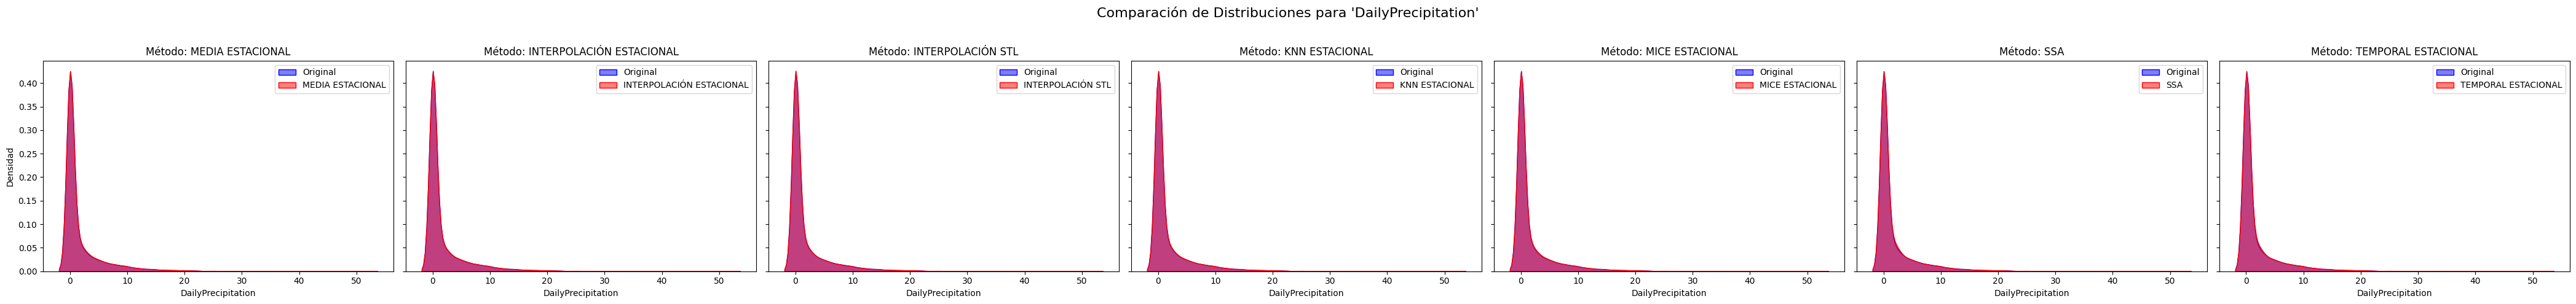

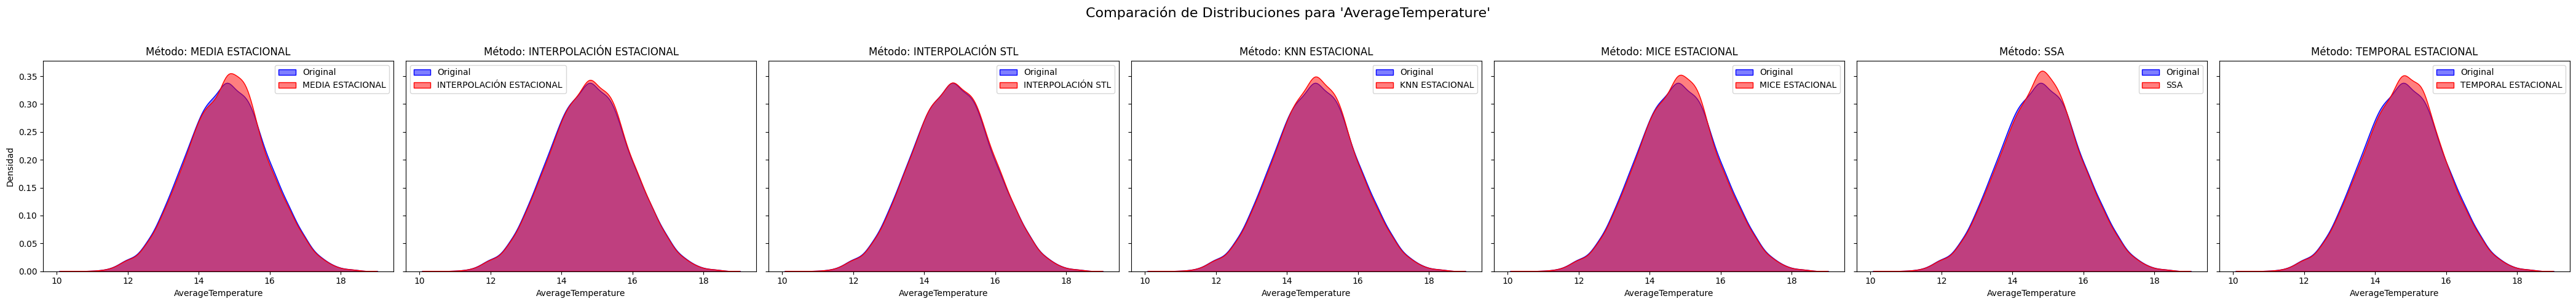

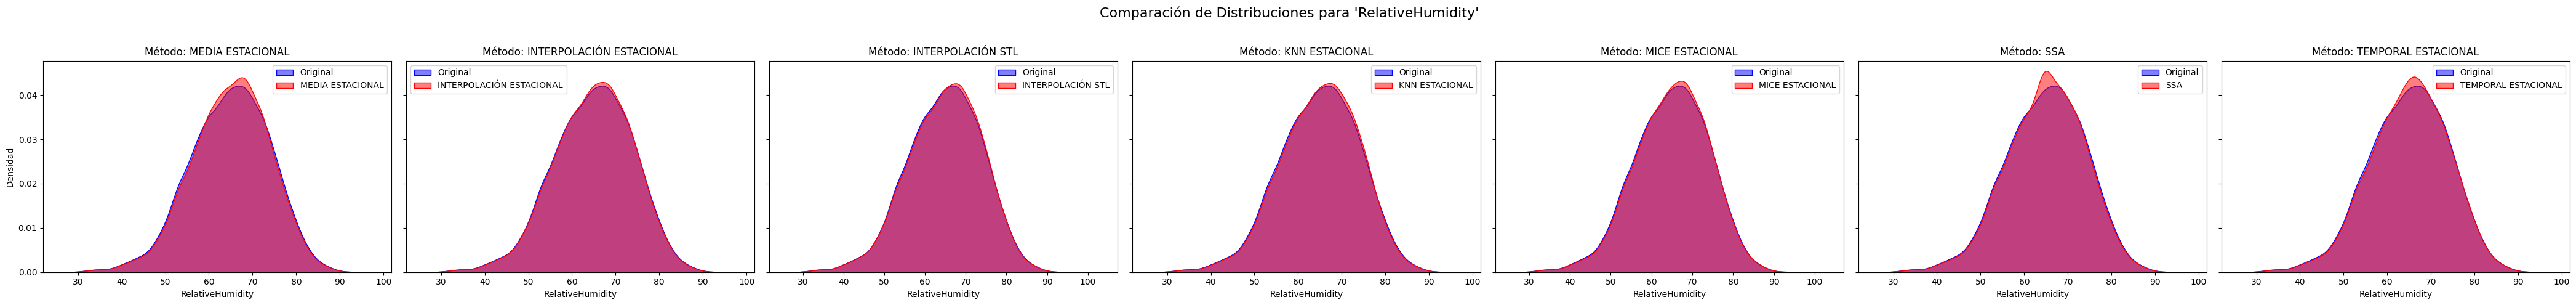

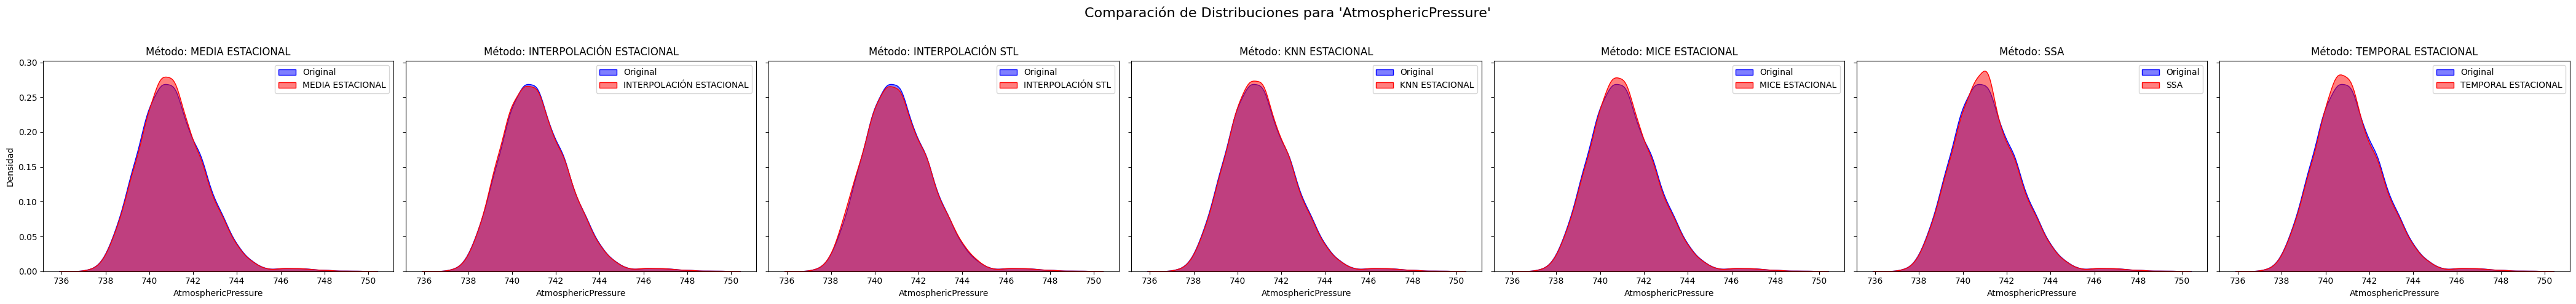

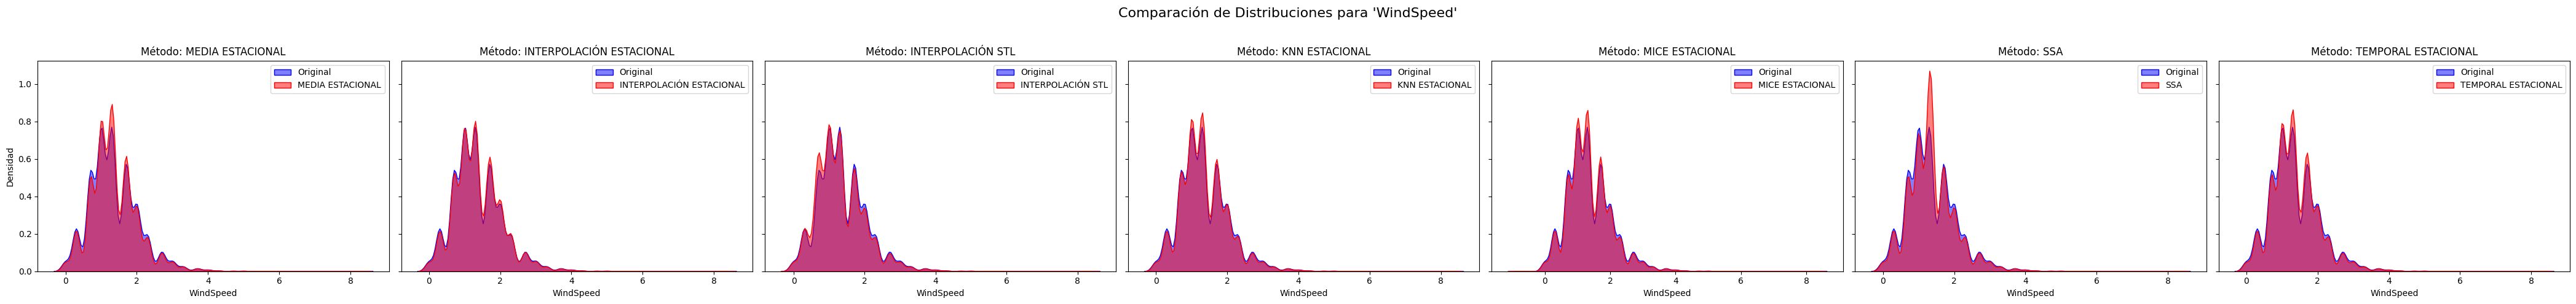

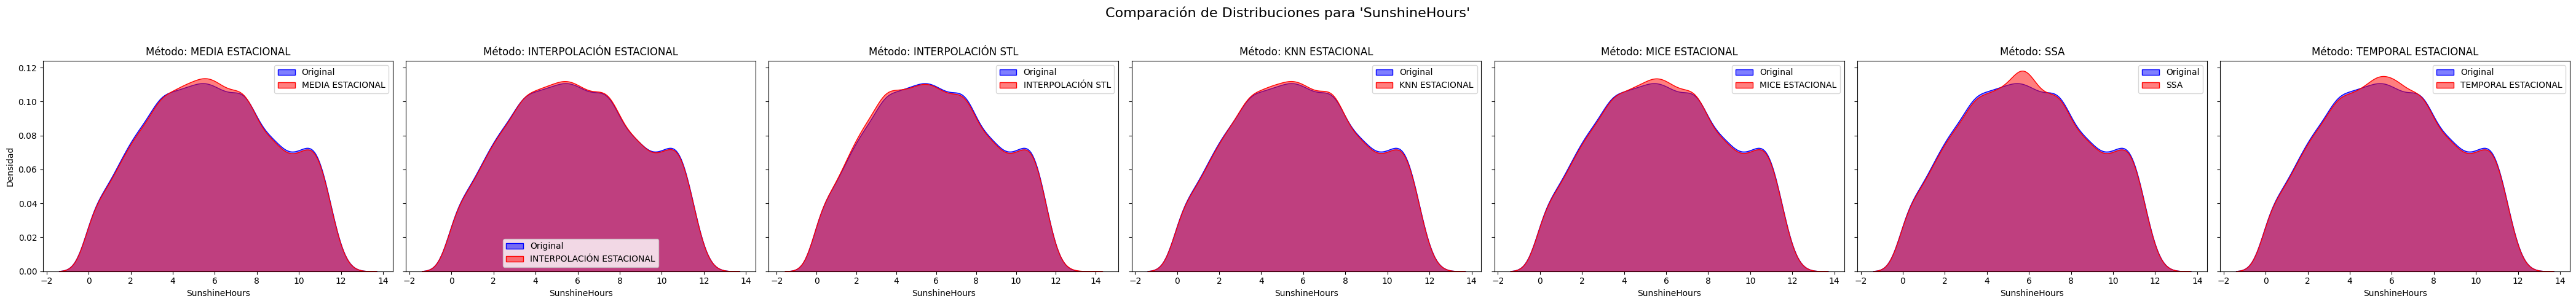

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", RuntimeWarning)


def comparar_distribuciones_lado_a_lado(df_original, df_imputados, variable, etiquetas, titulo=None):
    """
    Grafica las distribuciones de una variable antes y después de la imputación,
    mostrando los gráficos de los distintos métodos de imputación lado a lado.

    :param df_original: DataFrame con los datos originales.
    :param df_imputados: Lista de DataFrames con los datos imputados.
    :param variable: Nombre de la variable a comparar.
    :param etiquetas: Lista de etiquetas para cada DataFrame imputado.
    :param titulo: Título opcional para el conjunto de gráficos.
    """
    num_metodos = len(df_imputados)
    fig, axes = plt.subplots(1, num_metodos, figsize=(6 * num_metodos, 5), sharey=True)

    if titulo:
        fig.suptitle(titulo, fontsize=16)

    for ax, df_imputado, etiqueta in zip(axes, df_imputados, etiquetas):
        sns.kdeplot(df_original[variable].dropna(), label="Original", fill=True, alpha=0.5, color="blue", ax=ax)
        sns.kdeplot(df_imputado[variable].dropna(), label=etiqueta, fill=True, alpha=0.5, color="red", ax=ax)
        ax.set_title(f"Método: {etiqueta}")
        ax.set_xlabel(variable)
        ax.set_ylabel("Densidad")
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Lista de columnas a evaluar
columnas_a_imputar = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity', 'AtmosphericPressure', 'WindSpeed', 'SunshineHours']

# Lista de DataFrames imputados y sus etiquetas correspondientes
dataframes_imputados = [
    df_med_estacional, 
    df_interp_estacional,
    df_stl_interp, 
    df_knn_estacional,
    df_mice, 
    df_ssa, 
    df_temporal_estacional 
]
etiquetas_imputados =[
    'MEDIA ESTACIONAL', 
    'INTERPOLACIÓN ESTACIONAL',
    'INTERPOLACIÓN STL', 
    'KNN ESTACIONAL',
    'MICE ESTACIONAL', 
    'SSA', 
    'TEMPORAL ESTACIONAL'
]

# Generar los gráficos de comparación para cada variable
for columna in columnas_a_imputar:
    comparar_distribuciones_lado_a_lado(df_procesado, dataframes_imputados, columna, etiquetas_imputados,
                                        titulo=f"Comparación de Distribuciones para '{columna}'")

## 2. EVALUACION DE LA DINAMICA TEMPORAL

Funciones de Autocorrelación:

* ACF (Función de Autocorrelación): Compara los gráficos ACF de la serie original e imputada para asegurarte de que se preserven las correlaciones a distintos rezagos.

* PACF (Función de Autocorrelación Parcial): Verifica que la dependencia directa entre observaciones se mantenga tras la imputación.

* EACF (Función de Autocorrelación Extendida): Es especialmente útil para identificar estructuras ARMA en series con componentes estacionales y no estacionales.

Preservación de Componentes de la Serie:

* Análisis de Descomposición: Utiliza métodos como STL o descomposición clásica para separar la serie en sus componentes (tendencia, estacionalidad y residual) antes y después de la imputación.

* Verifica que la amplitud y fase de los ciclos estacionales, así como la tendencia general, se mantengan, lo cual es crítico para variables como precipitación y temperatura.



Para elegir el mejor método de imputación, considera los siguientes criterios basados en los resultados obtenidos:

1. Preservación de la Dependencia Temporal (ACF y PACF)
ACF Diff y PACF Diff (Diferencia de ACF y PACF)

Menor valor es mejor: Una menor diferencia indica que el método de imputación mantiene mejor la estructura de correlación temporal.

Interpretación: Si los valores son altos, significa que la imputación ha alterado significativamente la relación entre observaciones a diferentes rezagos, lo que puede afectar la calidad del modelo predictivo.

2. Conservación de Componentes de la Serie Temporal
Tendencia Corr (Correlación de la Tendencia)

Más cercano a 1 es mejor: Indica que la tendencia general de la serie antes y después de la imputación es similar.

Interpretación: Un valor bajo sugiere que el método ha alterado la evolución a largo plazo de la variable.

Estacionalidad Corr (Correlación de la Estacionalidad)

Más cercano a 1 es mejor: Indica que la estructura estacional no se ha visto afectada por la imputación.

Importante para: Variables con ciclos claros, como temperatura o precipitación.

Residuo RMSE (Error Cuadrático Medio del Residuo)

Menor valor es mejor: Indica que las fluctuaciones residuales son similares antes y después de la imputación.

Interpretación: Un valor alto puede indicar que la imputación ha generado ruido adicional o alterado la variabilidad natural de la serie.

In [194]:
# Calculo de la dinamica temporal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL

# VARIABLES A EVALUAR
columnas_a_imputar = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity',
                      'AtmosphericPressure', 'WindSpeed', 'SunshineHours']

# Función para calcular diferencia de ACF y PACF
def calcular_acf_pacf_diferencia(original, imputado, lags=30):
    original = original.dropna()
    imputado = imputado.dropna()
    min_len = min(len(original), len(imputado))
    original, imputado = original.iloc[:min_len], imputado.iloc[:min_len]

    acf_orig = acf(original, nlags=lags, fft=False)
    acf_imp = acf(imputado, nlags=lags, fft=False)
    pacf_orig = pacf(original, nlags=lags)
    pacf_imp = pacf(imputado, nlags=lags)

    acf_diff = np.mean(np.abs(acf_orig - acf_imp))
    pacf_diff = np.mean(np.abs(pacf_orig - pacf_imp))
    return acf_diff, pacf_diff

# Función para calcular preservación de componentes temporales
def calcular_preservacion_componentes(original, imputado, periodo_estacional=365):
    original = original.dropna()
    imputado = imputado.dropna()
    min_len = min(len(original), len(imputado))
    original, imputado = original.iloc[:min_len], imputado.iloc[:min_len]

    stl_orig = STL(original, period=periodo_estacional).fit()
    stl_imp = STL(imputado, period=periodo_estacional).fit()

    tendencia_corr = np.corrcoef(stl_orig.trend, stl_imp.trend)[0, 1]
    estacionalidad_corr = np.corrcoef(stl_orig.seasonal, stl_imp.seasonal)[0, 1]
    residuo_rmse = np.sqrt(np.mean((stl_orig.resid - stl_imp.resid) ** 2))

    return tendencia_corr, estacionalidad_corr, residuo_rmse

# DICCIONARIO DE IMPUTACIONES (ya predefinido en tu entorno)
df_imputaciones = {
    'Seasonal Mean Imputation':df_med_estacional, 
    'Seasonal Interpolation':df_interp_estacional,
    'STL-Based Interpolation':df_stl_interp, 
    'Seasonal KNN Imputation':df_knn_estacional,
    'Seasonal MICE Imputation':df_mice, 
    'SSA-based Imputation':df_ssa, 
    'Seasonal Temporal Regression Imputation':df_temporal_estacional 
}
# EVALUACIÓN
resultados = []
for metodo, df_imputado in df_imputaciones.items():
    for variable in columnas_a_imputar:
        original = df_procesado[variable]
        imputado = df_imputado[variable]

        acf_diff, pacf_diff = calcular_acf_pacf_diferencia(original, imputado)
        tendencia_corr, estacionalidad_corr, residuo_rmse = calcular_preservacion_componentes(original, imputado)

        resultados.append([
            metodo, variable,
            acf_diff, pacf_diff,
            tendencia_corr, estacionalidad_corr,
            residuo_rmse
        ])

# Crear DataFrame base
df_dinamica_temporal = pd.DataFrame(resultados, columns=[
    'Method', 'Variable',
    'ACF Diff', 'PACF Diff',
    'Trend Corr', 'Seasonality Corr',
    'Residual RMSE'
])

# Normalización
metricas_menor_mejor = ['ACF Diff', 'PACF Diff', 'Residual RMSE']
metricas_mayor_mejor = ['Trend Corr', 'Seasonality Corr']

# Normalizadores
scaler_menor = MinMaxScaler()
scaler_mayor = MinMaxScaler()

# Copia para normalización
df_dinamica_temporal[[col + ' (Norm)' for col in metricas_menor_mejor]] = 1 - scaler_menor.fit_transform(
    df_dinamica_temporal[metricas_menor_mejor])

df_dinamica_temporal[[col + ' (Norm)' for col in metricas_mayor_mejor]] = scaler_mayor.fit_transform(
    df_dinamica_temporal[metricas_mayor_mejor])

# Calcular score final (Score_Din_Temp) como promedio de columnas normalizadas
columnas_norm = [col + ' (Norm)' for col in metricas_menor_mejor + metricas_mayor_mejor]
df_dinamica_temporal['Temp_Dinamic_Score'] = df_dinamica_temporal[columnas_norm].mean(axis=1)

# Reordenar columnas
df_dinamica_temporal = df_dinamica_temporal[
    ['Variable', 'Method'] +
    metricas_menor_mejor + metricas_mayor_mejor +
    columnas_norm + ['Temp_Dinamic_Score']
]

# Ordenar por Variable
df_dinamica_temporal = df_dinamica_temporal.sort_values(by='Variable').reset_index(drop=True)

# ============================
# MOSTRAR TODA LA TABLA COMPLETA
# ============================
display(df_dinamica_temporal)

,Variable,Method,ACF Diff,PACF Diff,Residual RMSE,Trend Corr,Seasonality Corr,ACF Diff (Norm),PACF Diff (Norm),Residual RMSE (Norm),Trend Corr (Norm),Seasonality Corr (Norm),Temp_Dinamic_Score
0,AtmosphericPressure,Seasonal Temporal Regression Imputation,0.002343,0.002197,0.276844,0.960477,0.364987,9.802528e-01,8.390096e-01,9.959364e-01,0.979272,0.698206,0.898535
1,AtmosphericPressure,Seasonal Mean Imputation,0.003454,0.002322,0.282779,0.958132,0.365464,9.617794e-01,8.245594e-01,9.943536e-01,0.975134,0.699093,0.890984
2,AtmosphericPressure,Seasonal KNN Imputation,0.006864,0.006035,0.287750,0.957202,0.361973,9.051186e-01,3.956160e-01,9.930279e-01,0.973491,0.692601,0.791971
3,AtmosphericPressure,Seasonal Interpolation,0.005683,0.002349,0.261607,0.971353,0.388179,9.247311e-01,8.214195e-01,1.000000e+00,0.998471,0.741334,0.897191
4,AtmosphericPressure,SSA-based Imputation,0.001154,0.001725,0.272674,0.962739,0.373477,1.000000e+00,8.935541e-01,9.970486e-01,0.983265,0.713993,0.917572
5,AtmosphericPressure,Seasonal MICE Imputation,0.004151,0.002609,0.284189,0.957745,0.364834,9.502037e-01,7.913386e-01,9.939775e-01,0.974451,0.697921,0.881578
6,AtmosphericPressure,STL-Based Interpolation,0.010485,0.001845,0.264274,0.972219,0.417245,8.449383e-01,8.797155e-01,9.992889e-01,1.000000,0.795383,0.903865
7,AverageTemperature,Seasonal Mean Imputation,0.018653,0.005664,0.507880,0.893678,0.089500,7.091896e-01,4.384737e-01,9.343197e-01,0.861354,0.185926,0.625853
8,AverageTemperature,Seasonal Temporal Regression Imputation,0.015891,0.005557,0.505974,0.889643,0.087522,7.550938e-01,4.508434e-01,9.348280e-01,0.854231,0.182248,0.635449
9,AverageTemperature,Seasonal KNN Imputation,0.021255,0.005855,0.508157,0.893237,0.090511,6.659462e-01,4.163947e-01,9.342458e-01,0.860575,0.187807,0.612994


In [196]:

# ============================
# MOSTRAR SOLO LOS MEJORES POR VARIABLE
# ============================
df_mejores_dinamica_temporal = df_dinamica_temporal.sort_values(
    by=['Variable', 'Temp_Dinamic_Score'],
    ascending=[True, False]
).groupby('Variable').first().reset_index()

# Mostrar resumen final
display(
    df_mejores_dinamica_temporal[['Variable', 'Method', 'Temp_Dinamic_Score']].style.hide(axis="index")
)


Variable,Method,Temp_Dinamic_Score
AtmosphericPressure,SSA-based Imputation,0.917572
AverageTemperature,STL-Based Interpolation,0.657091
DailyPrecipitation,SSA-based Imputation,0.972717
RelativeHumidity,STL-Based Interpolation,0.449898
SunshineHours,Seasonal Temporal Regression Imputation,0.784809
WindSpeed,Seasonal MICE Imputation,0.483856


## 3. EVALUACION DE LA ESTRUCTURA TEMPORAL Y LA COMPLEJIDAD

* Estadísticos de Reversibilidad Temporal:

  Calcula coeficientes que midan la simetría temporal y compáralos antes y después de la imputación para detectar cambios en la dinámica de la serie.

* Cruces por Cero y Persistencia:

  Analiza la frecuencia de cruces por el nivel medio y la duración de periodos por encima o por debajo de ciertos umbrales, lo que es útil para detectar alteraciones en variables como precipitación o velocidad del viento.

* Análisis de Recurrencia:

  Utiliza gráficos de recurrencia (RP) y análisis de cuantificación de recurrencia (RQA) para evaluar métricas como determinismo, entropía y laminaridad, permitiendo detectar cambios sutiles en la dinámica temporal.

* Métricas de Información:

  Calcula la entropía aproximada (ApEn), la entropía muestral (SampEn) o la información mutua en distintos rezagos. Estas medidas ayudan a identificar alteraciones en la complejidad y predictibilidad de la serie.

In [ ]:
# ========================
# 1. INSTALAR DEPENDENCIAS
# ========================
!pip install -q antropy pyunicorn

In [197]:
# ========================
# 2. IMPORTAR LIBRERÍAS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from antropy import sample_entropy, app_entropy
from pyunicorn.timeseries import RecurrencePlot
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler

# ========================
# 3. FUNCIONES DE MÉTRICAS
# ========================
def calcular_reversibilidad_temporal(serie):
    return np.mean(np.abs(serie.diff().dropna()))

def calcular_cruces_por_cero(serie):
    return np.sum(np.diff(np.sign(serie - serie.mean())) != 0)

def calcular_recurrencia(serie, threshold=0.1):
    serie = serie.dropna().values
    rp = RecurrencePlot(serie, threshold=threshold)
    determinismo = rp.determinism()
    laminaridad = rp.laminarity()
    rec_matrix = rp.recurrence_matrix()
    histograma = np.sum(rec_matrix, axis=1)
    entropia_rqa = entropy(histograma + 1e-10)
    return determinismo, entropia_rqa, laminaridad

def calcular_entropias(serie):
    serie = serie.dropna().values
    return sample_entropy(serie, 2, 0.2 * np.std(serie)), app_entropy(serie, 2, 0.2 * np.std(serie))

# ========================
# 4. EVALUAR ESTRUCTURA TEMPORAL
# ========================
df_imputaciones = {
    'Seasonal Mean Imputation':df_med_estacional, 
    'Seasonal Interpolation':df_interp_estacional,
    'STL-Based Interpolation':df_stl_interp, 
    'Seasonal KNN Imputation':df_knn_estacional,
    'Seasonal MICE Imputation':df_mice, 
    'SSA-based Imputation':df_ssa, 
    'Seasonal Temporal Regression Imputation':df_temporal_estacional 
}

estructura_resultados = []

for metodo, df in df_imputaciones.items():
    for var in columnas_a_imputar:
        serie = df[var]
        if serie.isnull().sum() > 0 or len(serie.dropna()) < 10:
            continue

        rev = calcular_reversibilidad_temporal(serie)
        cruz = calcular_cruces_por_cero(serie)
        det, ent_rqa, lam = calcular_recurrencia(serie)
        sampen, apen = calcular_entropias(serie)

        estructura_resultados.append([
            metodo, var, rev, cruz, det, ent_rqa, lam, sampen, apen
        ])

# ========================
# 5. CREAR DATAFRAME Y NORMALIZAR
# ========================
df_estructura_temporal = pd.DataFrame(estructura_resultados, columns=[
    'Method', 'Variable', 'Reversibility', 'Zero Crossings',
    'Determinism', 'RQA Entropy', 'Laminarity', 'SampEntropy', 'ApproxEntropy'
])

metricas_a_normalizar = [
    'Reversibility', 'Zero Crossings', 'Determinism',
    'Laminarity', 'RQA Entropy', 'SampEntropy', 'ApproxEntropy'
]

# Agregar columnas normalizadas con sufijo (Norm)
for var in columnas_a_imputar:
    df_var = df_estructura_temporal[df_estructura_temporal['Variable'] == var].copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_var[metricas_a_normalizar])
    for i, col in enumerate(metricas_a_normalizar):
        df_estructura_temporal.loc[df_var.index, col + ' (Norm)'] = scaled[:, i]

# ========================
# 6. CALCULAR SCORE NORMALIZADO
# ========================
df_estructura_temporal['Temp_Est_Score'] = (
    df_estructura_temporal['Reversibility (Norm)'] +
    df_estructura_temporal['Zero Crossings (Norm)'] +
    df_estructura_temporal['Determinism (Norm)'] +
    df_estructura_temporal['Laminarity (Norm)']
) - (
    df_estructura_temporal['RQA Entropy (Norm)'] +
    df_estructura_temporal['SampEntropy (Norm)'] +
    df_estructura_temporal['ApproxEntropy (Norm)']
)

display(
    df_estructura_temporal.style.hide(axis="index")
)


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculatin

,Method,Variable,Reversibility,Zero Crossings,Determinism,RQA Entropy,Laminarity,SampEntropy,ApproxEntropy,Reversibility (Norm),Zero Crossings (Norm),Determinism (Norm),Laminarity (Norm),RQA Entropy (Norm),SampEntropy (Norm),ApproxEntropy (Norm),Temp_Est_Score
0,Seasonal Mean Imputation,DailyPrecipitation,2.256901,2679,0.789836,8.831980,0.898319,0.335361,1.051769,0.322800,0.450000,0.678314,0.435663,0.229637,0.111929,0.766841,0.778370
1,Seasonal Mean Imputation,AverageTemperature,0.806120,3308,0.109823,9.192013,0.164589,1.824650,1.930305,0.308317,0.608696,0.706430,0.574701,0.000000,0.517807,0.417115,1.263221
2,Seasonal Mean Imputation,RelativeHumidity,4.859321,2400,0.025264,9.218872,0.039968,1.650963,1.826838,0.417893,0.693333,0.241230,0.126145,0.635561,0.965324,0.958930,-1.081213
3,Seasonal Mean Imputation,AtmosphericPressure,0.489118,1500,0.197671,9.218368,0.283617,1.135931,1.263748,0.187684,0.163636,0.730623,0.717935,0.284181,0.296262,0.200244,1.019191
4,Seasonal Mean Imputation,WindSpeed,0.478054,3382,0.312940,9.187655,0.435518,1.525968,1.767084,0.269212,0.462766,0.153988,0.382536,0.646173,0.779947,0.408366,-0.565984
5,Seasonal Mean Imputation,SunshineHours,2.403925,3767,0.048858,9.236015,0.069455,1.882163,2.001588,0.300411,0.481481,0.093521,0.043144,0.254470,0.829002,0.691034,-0.855948
6,Seasonal Interpolation,DailyPrecipitation,2.272867,2701,0.788522,8.835466,0.897736,0.337448,1.053030,1.000000,1.000000,0.000000,0.000000,0.855690,1.000000,1.000000,-0.855690
7,Seasonal Interpolation,AverageTemperature,0.819469,3368,0.105768,9.198021,0.147975,1.853960,1.942541,1.000000,0.934783,0.000000,0.000000,0.592470,1.000000,1.000000,-0.657688
8,Seasonal Interpolation,RelativeHumidity,4.980258,2446,0.024486,9.217575,0.037657,1.648325,1.800656,1.000000,1.000000,0.000000,0.036503,0.226786,0.927793,0.484858,0.397066
9,Seasonal Interpolation,AtmosphericPressure,0.495628,1486,0.194961,9.223740,0.265747,1.154530,1.269085,0.502700,0.036364,0.424745,0.100065,1.000000,0.701766,0.374638,-1.012532


Selección del mejor método de imputación por estructura temporal:



Variable,Method,Reversibility,Zero Crossings,Determinism,RQA Entropy,Laminarity,SampEntropy,ApproxEntropy,Temp_Est_Score
AtmosphericPressure,SSA-based Imputation,0.485239,1482,0.200057,9.216235,0.291774,1.122342,1.257621,2.000000
AverageTemperature,SSA-based Imputation,0.800170,3264,0.111508,9.192326,0.176884,1.793175,1.921548,2.338682
DailyPrecipitation,SSA-based Imputation,2.249290,2661,0.790460,8.830701,0.899075,0.336455,1.047624,1.422616
RelativeHumidity,SSA-based Imputation,4.774002,2336,0.027710,9.216855,0.062503,1.583103,1.807048,1.673293
SunshineHours,SSA-based Imputation,2.396652,3743,0.050331,9.234817,0.082187,1.846153,1.994255,2.037037
WindSpeed,SSA-based Imputation,0.466337,3208,0.380710,9.172803,0.505676,0.922959,1.700882,2.000000


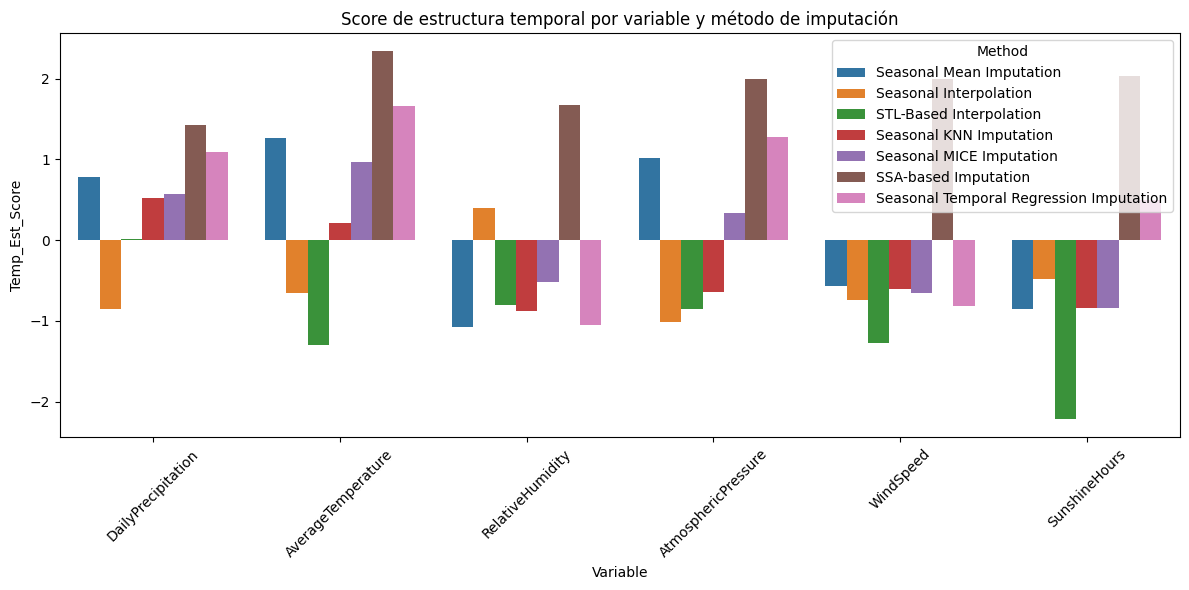

In [199]:
# ========================
# 7. MEJOR MÉTODO POR VARIABLE
# ========================
df_mejores = df_estructura_temporal.sort_values(
    by=['Variable', 'Temp_Est_Score'], ascending=[True, False]
).groupby('Variable').first().reset_index()

# (Opcional) Calcular justificación, aunque no se mostrará
def justificar(fila):
    return (f"El método '{fila['Method']}' fue seleccionado para la variable '{fila['Variable']}' "
            f"por presentar la mejor combinación de alta estructura temporal "
            f"(Determinismo={fila['Determinism']:.2f}, Laminaridad={fila['Laminarity']:.2f}, "
            f"Reversibilidad={fila['Reversibility']:.2f}) y baja entropía "
            f"(Entropía RQA={fila['RQA Entropy']:.2f}, SampEn={fila['SampEntropy']:.2f}, ApEn={fila['ApproxEntropy']:.2f}).")

df_mejores['Justificación'] = df_mejores.apply(justificar, axis=1)

# ========================
# 8. MOSTRAR RESULTADOS
# ========================
columnas_salida = [
    'Variable', 'Method', 'Reversibility', 'Zero Crossings',
    'Determinism', 'RQA Entropy', 'Laminarity',
    'SampEntropy', 'ApproxEntropy', 'Temp_Est_Score'
]

print("Selección del mejor método de imputación por estructura temporal:\n")

display(
    df_mejores[columnas_salida].style.hide(axis="index")
)

# ========================
# 9. VISUALIZACIÓN
# ========================
plt.figure(figsize=(12, 6))
sns.barplot(data=df_estructura_temporal, x='Variable', y='Temp_Est_Score', hue='Method')
plt.xticks(rotation=45)
plt.title("Score de estructura temporal por variable y método de imputación")
plt.tight_layout()
plt.show()


## Criterios para la Selección del Mejor Método por Variable (`Score_Est_Temp`)

### ¿Qué mide `Score_Est_Temp`?

El **`Score_Est_Temp`** es un índice compuesto que evalúa qué tan bien una serie imputada conserva la **estructura temporal** de la serie original. Se construye a partir de métricas que capturan la complejidad, la regularidad y los patrones dinámicos de la serie.

La fórmula general es:

### 🧮 Fórmula del `Score_Est_Temp`

```text
Score_Est_Temp = (
    Reversibilidad (normalizada)
  + Cruces por Cero (normalizada)
  + Determinismo (normalizado)
  + Laminaridad (normalizada)
) - (
    Entropía RQA (normalizada)
  + SampEn (normalizada)
  + ApEn (normalizada)
)


---

### ✅ ¿Qué representa cada grupo de métricas?

- **Métricas que SUMAN al score (estructura positiva)**:
  - **Reversibilidad**: indica simetría en la dinámica temporal.
  - **Cruces por Cero**: mide la alternancia en torno al promedio.
  - **Determinismo**: representa patrones repetitivos y predecibles.
  - **Laminaridad**: mide la permanencia en estados similares.

- **Métricas que RESTAN al score (complejidad o aleatoriedad)**:
  - **Entropía RQA**: mide la dispersión de los patrones recurrentes.
  - **Sample Entropy (SampEn)**: refleja la imprevisibilidad de la serie.
  - **Approximate Entropy (ApEn)**: mide la irregularidad de las subsecuencias.

---

### 🧪 ¿Por qué se normalizan las métricas?

Cada métrica tiene una escala distinta. Para compararlas de forma equitativa, se aplicó **normalización Min-Max** dentro de cada variable, asegurando que todas contribuyan de manera proporcional al `Score_Est_Temp`.

---

### 🥇 ¿Cuál fue el criterio de selección del mejor método?

Para cada variable:

1. Se calcularon todos los valores de `Score_Est_Temp` para los distintos métodos de imputación.
2. Se seleccionó el **método que obtuvo el valor más alto del score**, es decir:

> **El mejor método es el que maximiza el `Score_Est_Temp`**.

Esto se implementó mediante:

```python
df_estructura_temporal.sort_values(
    by=['Variable', 'Score_Est_Temp'], ascending=[True, False]
).groupby('Variable').first()


## 4. CONSERVACION DE EVENTOS EXTREMOS
* Eventos Máximos y Mínimos:

  Analiza la distribución de valores extremos (máximos y mínimos) por periodos y verifica que la intensidad y frecuencia de estos eventos se mantengan tras la imputación, aspecto especialmente relevante en variables ambientales.


In [200]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# ===========
# 1. PARÁMETROS
# ===========
variables = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity',
             'AtmosphericPressure', 'WindSpeed', 'SunshineHours']

imputaciones = {
    'Seasonal Mean Imputation':df_med_estacional, 
    'Seasonal Interpolation':df_interp_estacional,
    'STL-Based Interpolation':df_stl_interp, 
    'Seasonal KNN Imputation':df_knn_estacional,
    'Seasonal MICE Imputation':df_mice, 
    'SSA-based Imputation':df_ssa, 
    'Seasonal Temporal Regression Imputation':df_temporal_estacional 
}

df_procesado = df_procesado.copy()
df_procesado.index = pd.to_datetime(df_procesado.index)

# ===========
# 2. FUNCIÓN DE EVALUACIÓN DE EXTREMOS
# ===========
def evaluar_eventos_extremos(df_original, df_imputado, variable):
    df_original = df_original.copy()
    df_imputado = df_imputado.copy()
    df_original.index = pd.to_datetime(df_original.index)
    df_imputado.index = pd.to_datetime(df_imputado.index)

    # Eliminar NaN y extraer año
    df_orig_clean = df_original[[variable]].dropna()
    df_orig_clean['Year'] = df_orig_clean.index.year
    df_imputado['Year'] = df_imputado.index.year

    # Obtener extremos por año
    extremos_orig = df_orig_clean.groupby('Year')[variable].agg(['max', 'min'])
    extremos_imp = df_imputado.groupby('Year')[variable].agg(['max', 'min'])

    # Intersección de años válidos
    anios_comunes = extremos_orig.index.intersection(extremos_imp.index)
    if len(anios_comunes) == 0:
        return None

    # MAE de extremos
    mae_max = mean_absolute_error(extremos_orig.loc[anios_comunes]['max'],
                                  extremos_imp.loc[anios_comunes]['max'])
    mae_min = mean_absolute_error(extremos_orig.loc[anios_comunes]['min'],
                                  extremos_imp.loc[anios_comunes]['min'])

    # Normalización por rango
    rango = df_orig_clean[variable].max() - df_orig_clean[variable].min()
    mae_max_norm = mae_max / rango if rango != 0 else 0
    mae_min_norm = mae_min / rango if rango != 0 else 0

    # Score final (1 = perfecto, 0 = pobre)
    score = 1 - (mae_max_norm + mae_min_norm) / 2

    return mae_max, mae_min, mae_max_norm, mae_min_norm, score

# ===========
# 3. EVALUACIÓN GLOBAL DE MÉTODOS
# ===========
resultados = []

for metodo, df_imp in imputaciones.items():
    for var in variables:
        resultado = evaluar_eventos_extremos(df_procesado, df_imp, var)
        if resultado is not None:
            mae_max, mae_min, mae_max_norm, mae_min_norm, score = resultado
            resultados.append({
                'Variable': var,
                'Method': metodo,
                'MAE_Max': mae_max,
                'MAE_Min': mae_min,
                'MAE_Max_Norm': mae_max_norm,
                'MAE_Min_Norm': mae_min_norm,
                'Ext_Events_Score': score
            })

# Crear DataFrame y ordenar
df_eventos_extremos = pd.DataFrame(resultados)
df_eventos_extremos = df_eventos_extremos.sort_values(by=['Variable', 'Ext_Events_Score'], ascending=[True, False])

# Mostrar resultado ordenado por Variable
display(df_eventos_extremos)





,Variable,Method,MAE_Max,MAE_Min,MAE_Max_Norm,MAE_Min_Norm,Ext_Events_Score
3,AtmosphericPressure,Seasonal Mean Imputation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
33,AtmosphericPressure,SSA-based Imputation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
39,AtmosphericPressure,Seasonal Temporal Regression Imputation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
15,AtmosphericPressure,STL-Based Interpolation,3.441958e-03,0.000000e+00,2.627449e-04,0.000000e+00,0.999869
27,AtmosphericPressure,Seasonal MICE Imputation,7.328467e-03,0.000000e+00,5.594249e-04,0.000000e+00,0.999720
9,AtmosphericPressure,Seasonal Interpolation,4.354839e-02,0.000000e+00,3.324304e-03,0.000000e+00,0.998338
21,AtmosphericPressure,Seasonal KNN Imputation,5.806452e-02,3.419355e-02,4.432406e-03,2.610195e-03,0.996479
1,AverageTemperature,Seasonal Mean Imputation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
7,AverageTemperature,Seasonal Interpolation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
13,AverageTemperature,STL-Based Interpolation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000


In [202]:
# ===========
# 4. MEJOR MÉTODO POR VARIABLE
# ===========
df_top_extremos = df_eventos_extremos.sort_values(by=['Variable', 'Ext_Events_Score'], ascending=[True, False])
df_mejor_extremos = df_top_extremos.groupby('Variable', as_index=False).first()


# ===========
# 6. RESULTADOS
# ===========
print("MEJOR MÉTODO PARA CONSERVACIÓN DE EXTREMOS:")
display(df_mejor_extremos[['Variable', 'Method', 'MAE_Max','MAE_Min','Ext_Events_Score']].style.hide(axis="index"))



MEJOR MÉTODO PARA CONSERVACIÓN DE EXTREMOS:


Variable,Method,MAE_Max,MAE_Min,Ext_Events_Score
AtmosphericPressure,Seasonal Mean Imputation,0.000000,0.000000,1.000000
AverageTemperature,Seasonal Mean Imputation,0.000000,0.000000,1.000000
DailyPrecipitation,Seasonal Mean Imputation,0.000000,0.000000,1.000000
RelativeHumidity,Seasonal KNN Imputation,0.000000,0.000000,1.000000
SunshineHours,Seasonal Mean Imputation,0.000000,0.000000,1.000000
WindSpeed,SSA-based Imputation,0.000000,0.000000,1.000000


### 🎯 Evaluación de Conservación de Eventos Extremos

El objetivo de esta métrica es identificar qué métodos de imputación conservan mejor los **valores extremos anuales** (máximos y mínimos) de las series temporales originales.

---

#### 🧮 ¿Cómo se calcula el `Score_Eventos_Ext`?

Este score mide la similitud entre los valores extremos anuales (máximos y mínimos) de la serie original y la imputada. Se calcula con la siguiente fórmula:

Score_Eventos_Ext = 1 - (MAE_Max_Norm + MAE_Min_Norm) / 2


Donde:

- **MAE_Max_Norm**: Error absoluto medio entre los máximos anuales reales e imputados, **normalizado por el rango** de la variable.
- **MAE_Min_Norm**: Error absoluto medio entre los mínimos anuales reales e imputados, también normalizado.
- El **rango** es la diferencia entre el valor máximo y mínimo de la variable original.

---

#### 📈 Interpretación del Score

- Un valor **cercano a 1** indica una alta fidelidad en la conservación de los extremos.
- Un valor **cercano a 0** indica una pobre conservación de los extremos.
- El valor **1** es ideal: los extremos imputados coinciden exactamente con los reales.

---

#### 🏆 Criterio para Seleccionar el Mejor Método

Para cada variable, se selecciona el **método con el mayor valor de `Score_Eventos_Ext`**, ya que esto indica que dicho método conserva mejor los eventos extremos.

---


In [204]:
# ==========================================
# EVALUACIÓN INTEGRAL DE MÉTODOS DE IMPUTACIÓN
# ==========================================
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Pesos personalizados por variable
pesos_por_variable = {
    'DailyPrecipitation':    {'estructure': 0.20, 'dynamics': 0.20, 'extreme_events': 0.40, 'distributional_differences': 0.20},
    'AverageTemperature':    {'estructure': 0.30, 'dynamics': 0.30, 'extreme_events': 0.10, 'distributional_differences': 0.30},
    'RelativeHumidity':      {'estructure': 0.30, 'dynamics': 0.30, 'extreme_events': 0.10, 'distributional_differences': 0.30},
    'AtmosphericPressure':   {'estructure': 0.35, 'dynamics': 0.35, 'extreme_events': 0.10, 'distributional_differences': 0.20},
    'WindSpeed':             {'estructure': 0.25, 'dynamics': 0.20, 'extreme_events': 0.35, 'distributional_differences': 0.20},
    'SunshineHours':         {'estructure': 0.25, 'dynamics': 0.20, 'extreme_events': 0.35, 'distributional_differences': 0.20},
}

# 2. Renombrar columnas para consistencia
df_estructura_temporal = df_estructura_temporal.rename(columns={'Temp_Est_Score': 'Estructure_Score'})
df_dinamica_temporal = df_dinamica_temporal.rename(columns={'Temp_Dinamic_Score': 'Dinamics_Score'})
df_eventos_extremos = df_eventos_extremos.rename(columns={'Ext_Events_Score': 'Extreme_Events_Score'})
df_score_diferencias_relativas = df_score_diferencias_relativas.rename(columns={'WRD_Score': 'WRD_Score'})

# 3. Unificación de todas las métricas
df_all = df_estructura_temporal[['Variable', 'Method', 'Estructure_Score']].merge(
    df_dinamica_temporal[['Variable', 'Method', 'Dinamics_Score']], on=['Variable', 'Method']
).merge(
    df_eventos_extremos[['Variable', 'Method', 'Extreme_Events_Score']], on=['Variable', 'Method']
).merge(
    df_score_diferencias_relativas[['Variable', 'Method', 'WRD_Score']], on=['Variable', 'Method']
)

df_resultados_detallado = df_all.copy()

# 4. Normalización por variable
df_norm = df_all.copy()
for var in df_norm['Variable'].unique():
    idx = df_norm['Variable'] == var
    for col in ['Estructure_Score', 'Dinamics_Score', 'Extreme_Events_Score', 'WRD_Score']:
        df_norm.loc[idx, col + '_Norm'] = MinMaxScaler().fit_transform(df_norm.loc[idx, [col]])

# 5. Cálculo del Score Global con pesos personalizados
df_norm['Final_Global_Score'] = 0.0
for var in df_norm['Variable'].unique():
    pesos = pesos_por_variable[var]
    idx = df_norm['Variable'] == var
    df_norm.loc[idx, 'Final_Global_Score'] = (
        pesos['estructure']  * df_norm.loc[idx, 'Estructure_Score_Norm'] +
        pesos['dynamics']    * df_norm.loc[idx, 'Dinamics_Score_Norm'] +
        pesos['extreme_events']     * df_norm.loc[idx, 'Extreme_Events_Score_Norm'] +
        pesos['distributional_differences'] * df_norm.loc[idx, 'WRD_Score_Norm']
    )

df_resultados_normalizados = df_norm.copy()

# 6. Selección del mejor método por variable
df_mejores_metodos = df_resultados_normalizados.sort_values(
    by=['Variable', 'Final_Global_Score'], ascending=[True, False]
).groupby('Variable').first().reset_index()

# 7. Resultados
print("TABLA DETALLADA (Métricas originales):")
display(df_resultados_detallado)

print("TABLA NORMALIZADA Y SCORE FINAL:")
display(df_resultados_normalizados[[
    'Variable', 'Method',
    'Estructure_Score_Norm', 'Dinamics_Score_Norm', 'Extreme_Events_Score_Norm',
    'WRD_Score_Norm', 'Final_Global_Score'
]])



TABLA DETALLADA (Métricas originales):


,Variable,Method,Estructure_Score,Dinamics_Score,Extreme_Events_Score,WRD_Score
0,DailyPrecipitation,Seasonal Mean Imputation,0.778370,0.967774,1.000000,0.624369
1,AverageTemperature,Seasonal Mean Imputation,1.263221,0.625853,1.000000,0.243816
2,RelativeHumidity,Seasonal Mean Imputation,-1.081213,0.428157,0.999941,0.220837
3,AtmosphericPressure,Seasonal Mean Imputation,1.019191,0.890984,1.000000,0.511779
4,WindSpeed,Seasonal Mean Imputation,-0.565984,0.460852,0.999785,0.597876
5,SunshineHours,Seasonal Mean Imputation,-0.855948,0.782843,1.000000,0.312372
6,DailyPrecipitation,Seasonal Interpolation,-0.855690,0.967859,0.999113,0.350000
7,AverageTemperature,Seasonal Interpolation,-0.657688,0.618367,1.000000,0.775856
8,RelativeHumidity,Seasonal Interpolation,0.397066,0.412678,0.999672,0.442257
9,AtmosphericPressure,Seasonal Interpolation,-1.012532,0.897191,0.998338,0.323838


TABLA NORMALIZADA Y SCORE FINAL:


,Variable,Method,Estructure_Score_Norm,Dinamics_Score_Norm,Extreme_Events_Score_Norm,WRD_Score_Norm,Final_Global_Score
0,DailyPrecipitation,Seasonal Mean Imputation,0.717226,0.589832,1.000000,0.593215,0.780055
1,AverageTemperature,Seasonal Mean Imputation,0.704748,0.291604,0.000000,0.206394,0.360824
2,RelativeHumidity,Seasonal Mean Imputation,0.000000,0.415885,0.991291,0.231557,0.293362
3,AtmosphericPressure,Seasonal Mean Imputation,0.674424,0.788311,1.000000,0.772386,0.766434
4,WindSpeed,Seasonal Mean Imputation,0.216072,0.919680,0.944341,0.792485,0.726970
5,SunshineHours,Seasonal Mean Imputation,0.319606,0.971653,1.000000,0.109814,0.646195
6,DailyPrecipitation,Seasonal Interpolation,0.000000,0.596843,0.000000,0.000000,0.119369
7,AverageTemperature,Seasonal Interpolation,0.177390,0.121844,0.000000,0.905263,0.361349
8,RelativeHumidity,Seasonal Interpolation,0.536677,0.000000,0.951231,0.510224,0.409193
9,AtmosphericPressure,Seasonal Interpolation,0.000000,0.837732,0.527972,0.000000,0.346003


In [207]:

print("MEJOR MÉTODO POR VARIABLE:")
display(df_mejores_metodos[['Variable', 'Method', 'Final_Global_Score']].style.hide(axis="index"))

MEJOR MÉTODO POR VARIABLE:


Variable,Method,Final_Global_Score
AtmosphericPressure,SSA-based Imputation,1.000000
AverageTemperature,STL-Based Interpolation,0.600000
DailyPrecipitation,SSA-based Imputation,1.000000
RelativeHumidity,STL-Based Interpolation,0.667398
SunshineHours,SSA-based Imputation,0.795888
WindSpeed,SSA-based Imputation,0.988316


## 🧪 Evaluación Integral de Métodos de Imputación

La evaluación integral de los métodos de imputación se basa en la combinación de múltiples dimensiones relevantes para la calidad de los datos ambientales. Se han considerado cuatro ejes de evaluación:

- **Estructura temporal** (`Score_Estructura`): captura la complejidad y patrones de recurrencia del sistema.
- **Dinámica temporal** (`Score_Dinamica`): evalúa la preservación de la dinámica determinista/no lineal de la serie original.
- **Eventos extremos** (`Score_EventosExtremos`): mide qué tan bien se conservan los eventos extremos relevantes para la variable.
- **Diferencias estadísticas relativas** (`Score_DiferenciasRelativas`): analiza qué tan cercanas son las distribuciones estadísticas (media, desviación estándar, asimetría y curtosis) entre la serie imputada y la original.

Cada una de estas métricas fue **normalizada por variable**, y luego ponderada de forma personalizada para obtener un **Score Global Final**.

---

### ⚖️ Criterios de ponderación por variable

Dado que cada variable ambiental presenta propiedades distintas en cuanto a su comportamiento, dinámica y relevancia de eventos extremos, se han definido **pesos específicos** para cada dimensión de evaluación, por variable:

| Variable              | Estructura | Dinámica | Eventos Extremos | Diferencias |
|-----------------------|------------|----------|------------------|-------------|
| **DailyPrecipitation**     | 0.20       | 0.20     | **0.40**             | 0.20        |
| **AverageTemperature**     | 0.30       | 0.30     | 0.10             | **0.30**    |
| **RelativeHumidity**       | 0.30       | 0.30     | 0.10             | **0.30**    |
| **AtmosphericPressure**    | **0.35**   | **0.35** | 0.10             | 0.20        |
| **WindSpeed**              | 0.25       | 0.20     | **0.35**         | 0.20        |
| **SunshineHours**          | 0.25       | 0.20     | **0.35**         | 0.20        |

---

### 🧠 Justificación de los pesos

- **DailyPrecipitation**: La correcta imputación de eventos extremos (lluvias intensas, días secos) es crucial para esta variable. Por ello, se asigna un alto peso (0.40) a la métrica de eventos extremos.

- **AverageTemperature y RelativeHumidity**: Ambas variables son más continuas, con dinámicas estacionales bien definidas. Se prioriza la estructura, dinámica y concordancia estadística general.

- **AtmosphericPressure**: Es una variable estable y suavemente cambiante, con poca relevancia de eventos extremos. Se prioriza la conservación de su estructura y dinámica.

- **WindSpeed y SunshineHours**: Estas variables pueden contener interrupciones abruptas, ráfagas o días completamente nublados. Por tanto, se asigna una mayor importancia a la detección de eventos extremos.

---

### 🏁 Selección del mejor método

El **Score Global Final** se calcula como una combinación ponderada de las métricas normalizadas. Para cada variable, se selecciona como *mejor método* aquel con el **mayor Score Global**, indicando el mejor balance integral entre estructura, dinámica, eventos extremos y similitud estadística.



In [142]:
# Resultado final, creacion del dataframe imputado segun los resultados de la evaluacion de los mejores metodos de imputacion

# Diccionario de selección del mejor método por variable
seleccion_mejores_metodos = {
    'AtmosphericPressure': ('SSA', df_ssa),
    'AverageTemperature':  ('INTERPOLACIÓN STL', df_stl_interp),
    'DailyPrecipitation':  ('SSA', df_ssa),
    'RelativeHumidity':    ('INTERPOLACIÓN STL', df_stl_interp),
    'SunshineHours':       ('SSA', df_ssa),
    'WindSpeed':           ('SSA', df_ssa)
}


# Crear una copia del DataFrame original con las columnas auxiliares
df_imputado = df_procesado[['Year', 'Month', 'Day']].copy()
df_imputado.index = df_procesado.index  # Asegurar que ProcessDate se mantenga como índice

# Iterar sobre la selección de mejores métodos
for variable, (metodo, df_fuente) in seleccion_mejores_metodos.items():
    # Extraer la serie imputada de la variable desde el DataFrame correspondiente
    if variable in df_fuente.columns:
        serie_imputada = df_fuente[variable]
        # Asegurar que los índices coincidan
        serie_imputada = serie_imputada.reindex(df_imputado.index)
        # Agregar al DataFrame imputado
        df_imputado[variable] = serie_imputada
    else:
        print(f"[ADVERTENCIA] La variable '{variable}' no está en el DataFrame del método '{metodo}'")

# Reordenar columnas: primero fecha y componentes temporales, luego variables ambientales
columnas_ordenadas = ['Year', 'Month', 'Day'] + list(seleccion_mejores_metodos.keys())
df_imputado = df_imputado[columnas_ordenadas]




In [143]:
df_imputado

,Year,Month,Day,AtmosphericPressure,AverageTemperature,DailyPrecipitation,RelativeHumidity,SunshineHours,WindSpeed
ProcessDate,,,,,,,,,
1994-01-01,1994,1,1,740.1,14.9,0.2,76.2,6.8,1.300000
1994-01-02,1994,1,2,739.9,15.1,7.7,77.8,1.6,1.300000
1994-01-03,1994,1,3,739.5,14.0,0.0,73.1,6.8,1.700000
1994-01-04,1994,1,4,740.2,15.3,0.0,66.9,3.5,1.291187
1994-01-05,1994,1,5,740.1,15.1,5.1,72.0,6.2,2.000000
...,...,...,...,...,...,...,...,...,...
2024-12-27,2024,12,27,740.2,14.0,11.3,88.6,1.5,0.300000
2024-12-28,2024,12,28,740.7,15.2,9.9,79.8,2.3,0.300000
2024-12-29,2024,12,29,740.4,16.4,6.6,71.0,1.7,0.700000


In [144]:
# Ver total de valores faltantes por columna
print("Valores faltantes por variable:")
print(df_imputado.isna().sum())

# Ver si hay algún valor faltante en todo el DataFrame
if df_imputado.isna().sum().sum() == 0:
    print("No hay valores faltantes en df_imputado.")
else:
    print("Aún hay valores faltantes en df_imputado.")


Valores faltantes por variable:
Year                   0
Month                  0
Day                    0
AtmosphericPressure    0
AverageTemperature     0
DailyPrecipitation     0
RelativeHumidity       0
SunshineHours          0
WindSpeed              0
dtype: int64
No hay valores faltantes en df_imputado.


In [145]:
print("Resumen general del DataFrame imputado:")
print(df_imputado.info())

print("Dimensiones del DataFrame imputado:", df_imputado.shape)


Resumen general del DataFrame imputado:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1994-01-01 to 2024-12-31
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 11323 non-null  int64  
 1   Month                11323 non-null  int64  
 2   Day                  11323 non-null  int64  
 3   AtmosphericPressure  11323 non-null  float64
 4   AverageTemperature   11323 non-null  float64
 5   DailyPrecipitation   11323 non-null  float64
 6   RelativeHumidity     11323 non-null  float64
 7   SunshineHours        11323 non-null  float64
 8   WindSpeed            11323 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 1.1 MB
None
Dimensiones del DataFrame imputado: (11323, 9)


In [146]:
# Mostrar un ejemplo de valores antes y después para una variable
variable_ejemplo = 'DailyPrecipitation'

comparacion = pd.DataFrame({
    'Original': df_procesado[variable_ejemplo],
    'Imputado': df_imputado[variable_ejemplo]
})

# Mostrar las primeras 10 diferencias
diferencias = comparacion[df_procesado[variable_ejemplo].isna()]
print("Primeras diferencias imputadas:")
print(diferencias.head(10))


Primeras diferencias imputadas:
             Original  Imputado
ProcessDate                    
2008-12-01        NaN  2.109501
2008-12-02        NaN  2.052119
2008-12-03        NaN  2.005046
2008-12-04        NaN  1.970415
2008-12-05        NaN  1.950168
2008-12-06        NaN  1.945729
2008-12-07        NaN  1.957831
2008-12-08        NaN  1.986517
2008-12-09        NaN  2.031071
2008-12-10        NaN  2.090286


In [147]:
print("Conteo de valores imputados por variable (comparando con df_procesado):")

for variable in df_mejores_metodos['Variable'].unique():
    if variable in df_procesado.columns:
        n_imputados = df_procesado[variable].isna().sum()
        print(f"{variable}: {n_imputados} valores imputados")
    else:
        print(f"{variable}: ❌ columna no encontrada en df_procesado")



Conteo de valores imputados por variable (comparando con df_procesado):
AtmosphericPressure: 327 valores imputados
AverageTemperature: 396 valores imputados
DailyPrecipitation: 137 valores imputados
RelativeHumidity: 508 valores imputados
SunshineHours: 163 valores imputados
WindSpeed: 1288 valores imputados


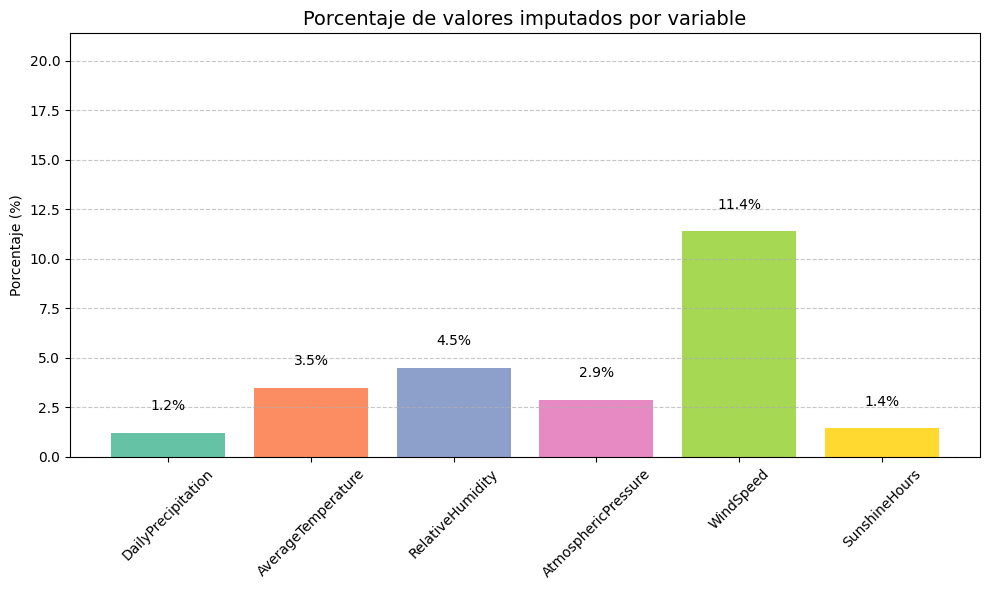

✅ No hay valores faltantes en df_imputado. No se muestra el mapa de calor.


In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asegúrate de que estos estén activados en Colab
%matplotlib inline

# ================================
# 1. Calcular % de valores imputados por variable
# ================================
variables_evaluadas = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity',
                       'AtmosphericPressure', 'WindSpeed', 'SunshineHours']

porcentaje_imputado = {}
for var in variables_evaluadas:
    n_total = len(df_procesado)
    n_imputados = df_procesado[var].isna().sum()
    porcentaje_imputado[var] = (n_imputados / n_total) * 100

# ================================
# 2. Gráfico de barras del porcentaje de imputación
# ================================
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(variables_evaluadas))

bars = plt.bar(porcentaje_imputado.keys(), porcentaje_imputado.values(), color=colors)

# Añadir etiquetas de porcentaje encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%", 
             ha='center', va='bottom', fontsize=10)

plt.title("Porcentaje de valores imputados por variable", fontsize=14)
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45)
plt.ylim(0, max(porcentaje_imputado.values()) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ================================
# 3. Mapa de calor de valores faltantes en df_imputado (si existen)
# ================================
if df_imputado.isna().sum().sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_imputado[variables_evaluadas].isna(), cbar=False, cmap='YlOrRd', yticklabels=False)
    plt.title("Mapa de calor de valores faltantes en df_imputado")
    plt.xlabel("Variables")
    plt.tight_layout()
    plt.show()
else:
    print("✅ No hay valores faltantes en df_imputado. No se muestra el mapa de calor.")


In [149]:
# Guardar el DataFrame imputado como CSV
nombre_archivo = 'dataset_imputed_senamhi30Year.csv'
df_imputado.to_csv(nombre_archivo, index=True)

# Confirmar ruta de guardado
import os
print(f"Archivo guardado en: {os.path.abspath(nombre_archivo)}")


Archivo guardado en: /Users/edwinvalencia/Projects/Research/climate-variables-senamhi-augusto-weberbauer-cajamarca-1994-2024/dataset_imputed_senamhi30Year.csv


## Correspondencia entre variable ambiental, metodo de imputacion y fundamento teorico
| **Variable**            | **Método Seleccionado** | **Justificación Científica**                                                                                                                                  |
| ----------------------- | ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **AtmosphericPressure** | SSA                     | Alta autocorrelación y estacionalidad suave; SSA permite descomposición en componentes deterministas y ruido estructurado, ideal para variables barométricas. |
| **AverageTemperature**  | Interpolación STL       | Presenta estacionalidad anual fuerte y tendencia suave; STL permite separar estas componentes antes de la interpolación.                                      |
| **DailyPrecipitation**  | SSA                     | SSA es adecuado para series discontínuas con eventos extremos, ya que permite separar componentes dominantes sin asumir linealidad o continuidad.             |
| **RelativeHumidity**    | Interpolación STL       | Alta estacionalidad anual y dependencia cruzada con temperatura; STL permite extracción de patrones cíclicos con precisión.                                   |
| **SunshineHours**       | SSA                     | Estacionalidad solar clara y alta variabilidad por nubosidad; SSA permite detectar y reconstruir patrones cíclicos mixtos.                                    |
| **WindSpeed**           | SSA                     | Alta variabilidad y autocorrelación diaria; SSA ha demostrado buena capacidad para modelar series de viento y reconstrucción de huecos.                       |
